In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [7]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")

해당 노트북은 Medical과 관련없는 캐글 대회이지만, EDA를 했었던 코드가 있기에 나중에 재사용하기 용이하도록 Classification 폴더에 같이 기재합니다.

이 노트북을 사용한 Data는

 https://www.kaggle.com/competitions/playground-series-s4e7

입니다.

최종 63등 기록

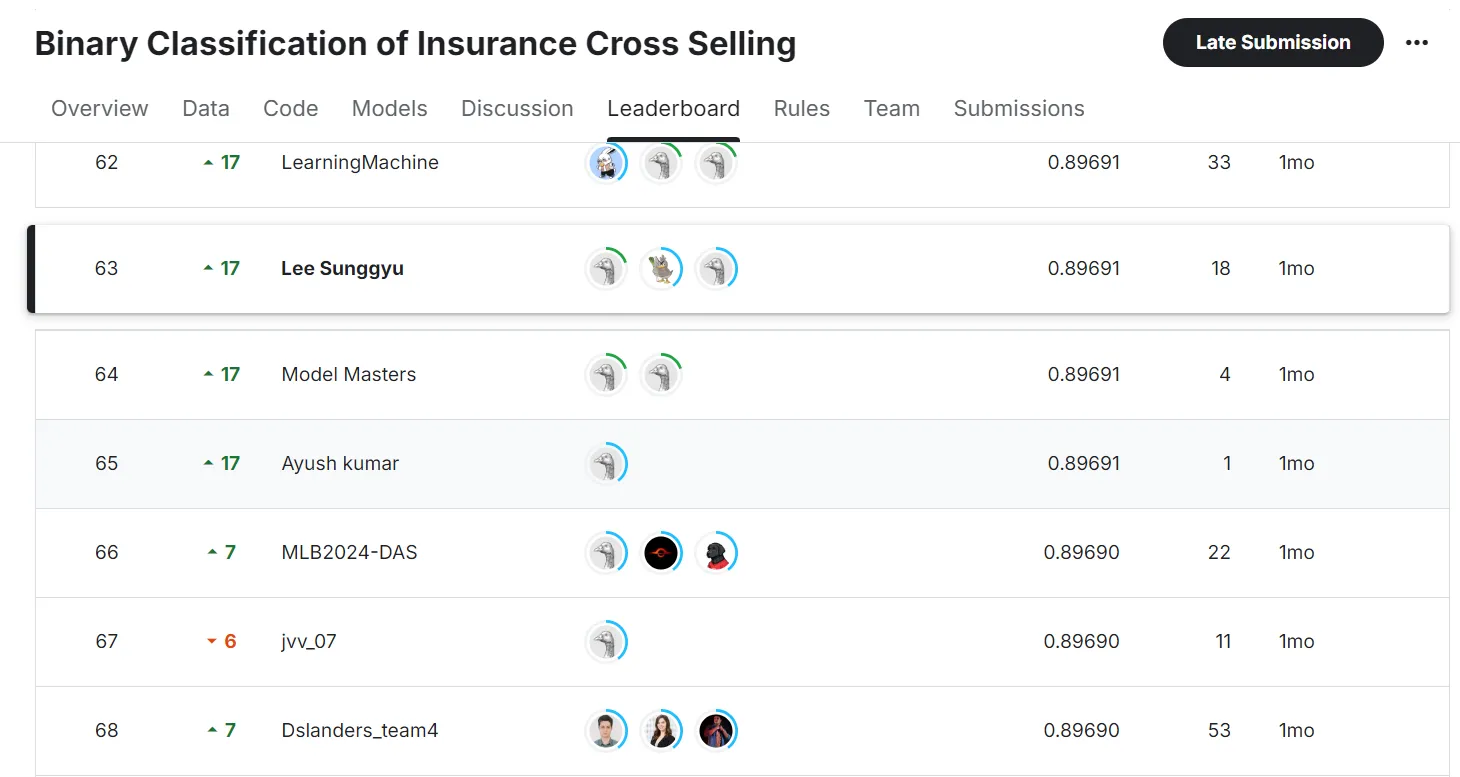

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터 오버 뷰

In [11]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    
    return summary

resumetable(df_train)

데이터 세트 형상: (11504798, 12)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,id,int64,0,11504798,0,1,2
1,Gender,object,0,2,Male,Male,Female
2,Age,int64,0,66,21,43,25
3,Driving_License,int64,0,2,1,1,1
4,Region_Code,float64,0,54,35.0,28.0,14.0
5,Previously_Insured,int64,0,2,0,0,1
6,Vehicle_Age,object,0,3,1-2 Year,> 2 Years,< 1 Year
7,Vehicle_Damage,object,0,2,Yes,Yes,No
8,Annual_Premium,float64,0,51728,65101.0,58911.0,38043.0
9,Policy_Sales_Channel,float64,0,152,124.0,26.0,152.0


In [12]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


# 데이터 각 칼럼을 보기

순서대로 번역
> id / 성별 / 나이 / 운전_면허증 / 지역_코드 / 이전_보험 가입 / 차량_연령 / 차량_손상 / 연간_프리미엄 / 정책_판매채널 / Vintage


- Response ( ) = 타겟 레이블
- "Vintage"는 고객이 보험에 가입한 후 경과된 개월 수로 파악되긴함

In [13]:
for col in df_train.columns:
    msg = "column: {:<20}\t Percent of NaN value: {:.2f}%".format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: id                  	 Percent of NaN value: 0.00%
column: Gender              	 Percent of NaN value: 0.00%
column: Age                 	 Percent of NaN value: 0.00%
column: Driving_License     	 Percent of NaN value: 0.00%
column: Region_Code         	 Percent of NaN value: 0.00%
column: Previously_Insured  	 Percent of NaN value: 0.00%
column: Vehicle_Age         	 Percent of NaN value: 0.00%
column: Vehicle_Damage      	 Percent of NaN value: 0.00%
column: Annual_Premium      	 Percent of NaN value: 0.00%
column: Policy_Sales_Channel	 Percent of NaN value: 0.00%
column: Vintage             	 Percent of NaN value: 0.00%
column: Response            	 Percent of NaN value: 0.00%


#### train 및 test 모두 위 오버뷰에서 보았듯 결측치는 없습니다.

# 데이터 전처리 메모
1. Region_Code - 이상치 하나 제거, One Hot 으로 하기엔 너무 많다고 판단 ( 데이터 많아서 학습 느려지므로 ) 타깃 인코딩, 프리퀀시 인코딩 찾아서 적절한 것 골라보기
2. 피처 스켈링 - 정규화를 진행할 것인데, 최댓값 최소값 할지 이상치를 분포를 시각화로 파악해야함.
3. Vehicle_Age 보니까 3개. 라벨 엔코딩 해도 괜찮을듯 상대적 순위에 따라서.
4. 정규화 할때, 이상치 파악 필수적 : min-max ( 대부분의 값과 동떨어진 값이 너무 크거나 작을때는 좋지않음 )
5. 4번이 안좋은 경우 정규화가아닌 표준화 적용 ( 정규분포를 따르는 데이터는 표준화 적용이 좋습니다. )

# 교차검증
1. K 폴드 교차 검증
**2. 층화 K 폴드 교차 검증 - 타깃값이 골고루 분포되게. <<<< 이번 대회의 경우 타깃이 너무 한쪽으로 치우쳐 있음. 고로 이것을 채용.**
#### **이번 대회의 경우 타깃이 너무 한쪽으로 치우쳐 있음.**

# 주요 머신러닝 모델

XGboost, LightGBM이 많이 쓰임. 단, 우리는 이번 대회에서 딥러닝을 채용할 예정도 있으므로 비교해서 더 높은 효능을 내는것을 생각해볼것 ( 단 , 너무 데이터가 많은 만큼 과적합도 고려해야함 )

그래도 간략히 종류를 나열해서 조금 설명하겠음

1. 선형 회귀 모델 - 안씀
2. 로지스틱 회귀 모델
3. 결정 트리
4. 앙상블 학습 - 다양한 모델이 내린 예측 결과를 결합하는 기법.
> 보팅 :
- 하드보팅: 다수결 투표로 최종 예측값 정함
- 소프트보팅 : 개별 예측 확률들의 평균으로 최종 예측 확률로 정함
- 하드 보팅보단 소프트 보팅이 효율 좋음

> 배깅 :
- 개별 모델로 예측한 결과를 결합해 최종 예측. (랜덤포레스트)

> 부스팅 :
- 가중치 활용해 분류 성능 약한 모델 강하게 하기 (XGboost, LightGBM)

5. 랜덤 포레스트

6. XGboost  - 이거 쓰고자함

7. LightGBM - 성능은 6번과 비슷하지만 훈련 속도가 더 빨라서 많이 애용

> 6,7번 장단덤 : 
- 피쳐 스케일링이 따로 필요 없습니다. 데이터의 절대적인 크기보다는 대소 관계에 영향을 받기 때문입니다.
- 레이블 인코딩을 적용해도 됩니다. 레이블 인코딩은 단점이 있다고 했지만, 트리 기반 모델의 특성상 분기를 거듭하면서 레이블 인코딩된 피처에서도 정보를 잘 추출할 수 있기 때문입니다.
- 결측값을 알아서 처리해줍니다. ( 그럼에도 더 명확하게 하려면 결측값을 별도로 처리하는 습관을 들이는게 바람직합니다. )

반면 선형 모델은 피처 스케일링, 결측값 처리, 원핫 인코딩을 해줘야 일반적으로 성능이 좋아집니다.


# 하이퍼 파라미터
- 그리드서치
- 랜덤 서치
- 베이지안 최적화

In [14]:
# 비율 표시 코드 함수
def write_percent(ax,total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x 축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0,     # x축 위치
                y=height + total_size*0.001,  # y축 위치
                s=f'{percent:1.1f}%',          # 입력 텍스트
                ha='center')                  # 가운데 정렬

# 타겟 값 확인

Text(0.5, 1.0, 'df_train Response')

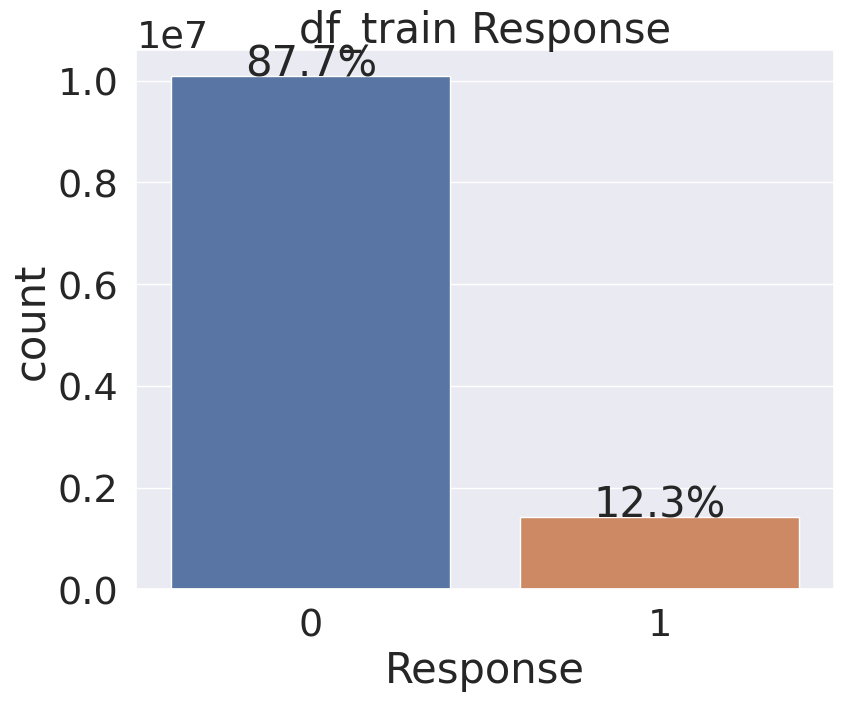

In [15]:
plt.figure(figsize=(9,7))

ax = sns.countplot(x='Response',data=df_train)
write_percent(ax, len(df_train)) # 비율 표시
ax.set_title("df_train Response")

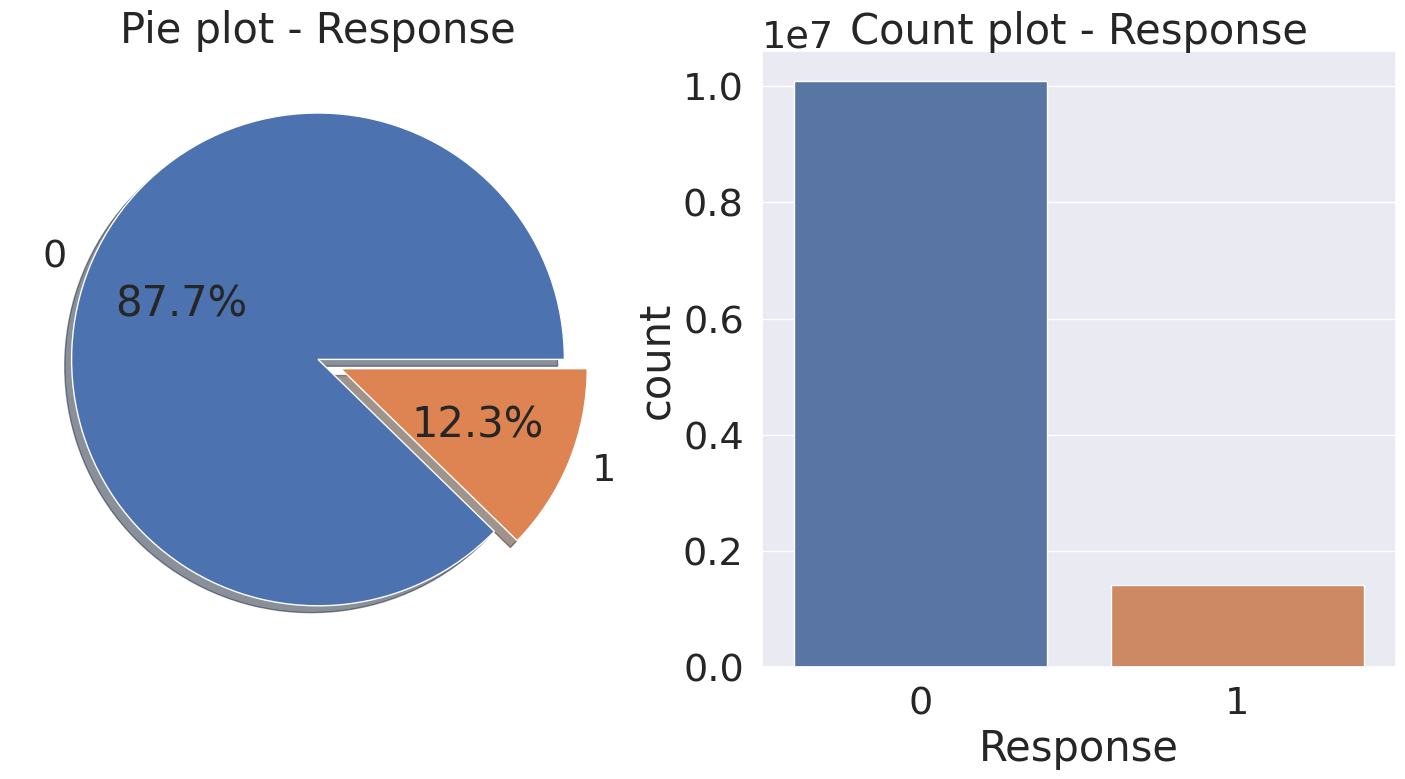

In [33]:
f, ax = plt.subplots(1,2, figsize=(18,8))

df_train["Response"].value_counts().plot.pie(explode=[0,0.1], autopct = '%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Response')
ax[0].set_ylabel('')
sns.countplot(df_train, x="Response" ,ax=ax[1]) # 왜안되..지?
ax[1].set_title('Count plot - Response')
plt.show()

## 타겟값이 0이 87.7% , 1이 12.3% 입니다.

### 전체 보험 교차 판매 응답중 12.3%만이 응답했다는 뜻입니다. 보험을 많이 안드는 편입니다. 타겟값이 불균형합니다.

타깃값이 불균형하기 때문에 비율이 작은 타깃값 1을 잘 예측하는게 중요합니다. 따라서 각 피처의 분포를 알아보기 보다는, 각 피처의 고윳값별 타깃값 1의 비율을 알아보는것이 매우 유리합니다. 고윳값별 타깃값 1 비율을 통해 해당 피처가 모델링에 필요한 피처인지 확인할 수 있습니다. 

( Tip 타깃값의 비율 차이가 크면 비율이 작은 타깃값을 잘 예측하는 게 중요합니다 )

# ( 안읽어도 됨. 팁 구성 )
- 각각의 고윳값마다 타깃값 비율이 다른 피처여야 모델링이 도움 됩니다.
- 통계적 유효성이 높아야( 신뢰구간이 좁아야 ) 모델링에 도움이 됩니다.

**즉, 고윳값별 타깃값 1 비율이 충분히 차이가 나고 신뢰구간도 작은 피처여야 모델링에 도움이 됩니다. 그렇지 않은 피처는 제거하는 게 좋습니다.**

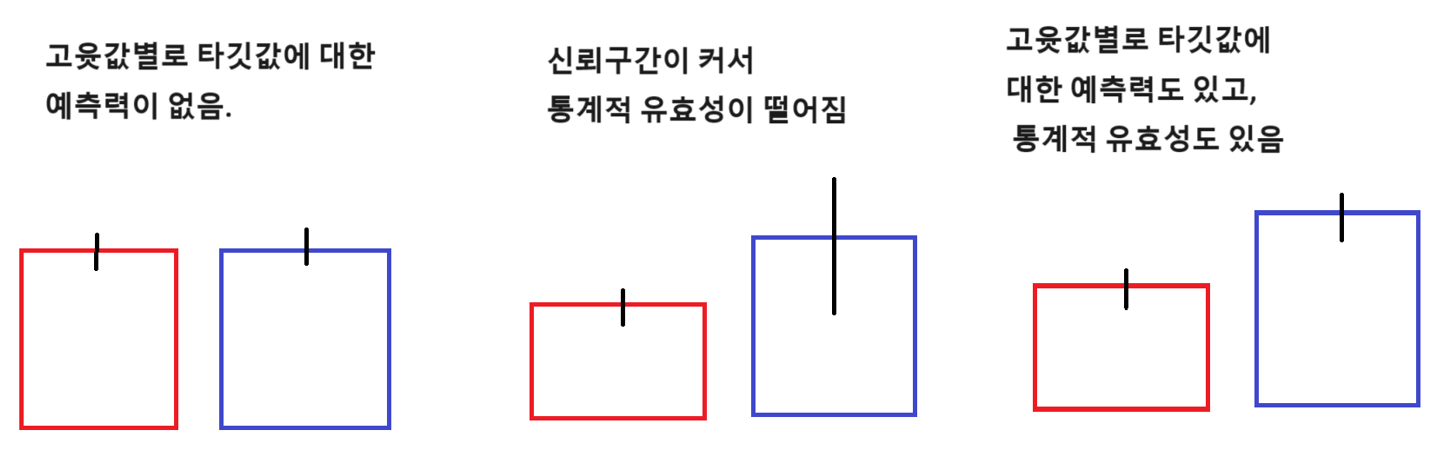

# 데이터 전체 구조 리뷰
## 이진 피처 분포 파악
- Gender , Driving_License, Previously_Insured, Vehicle_Damage


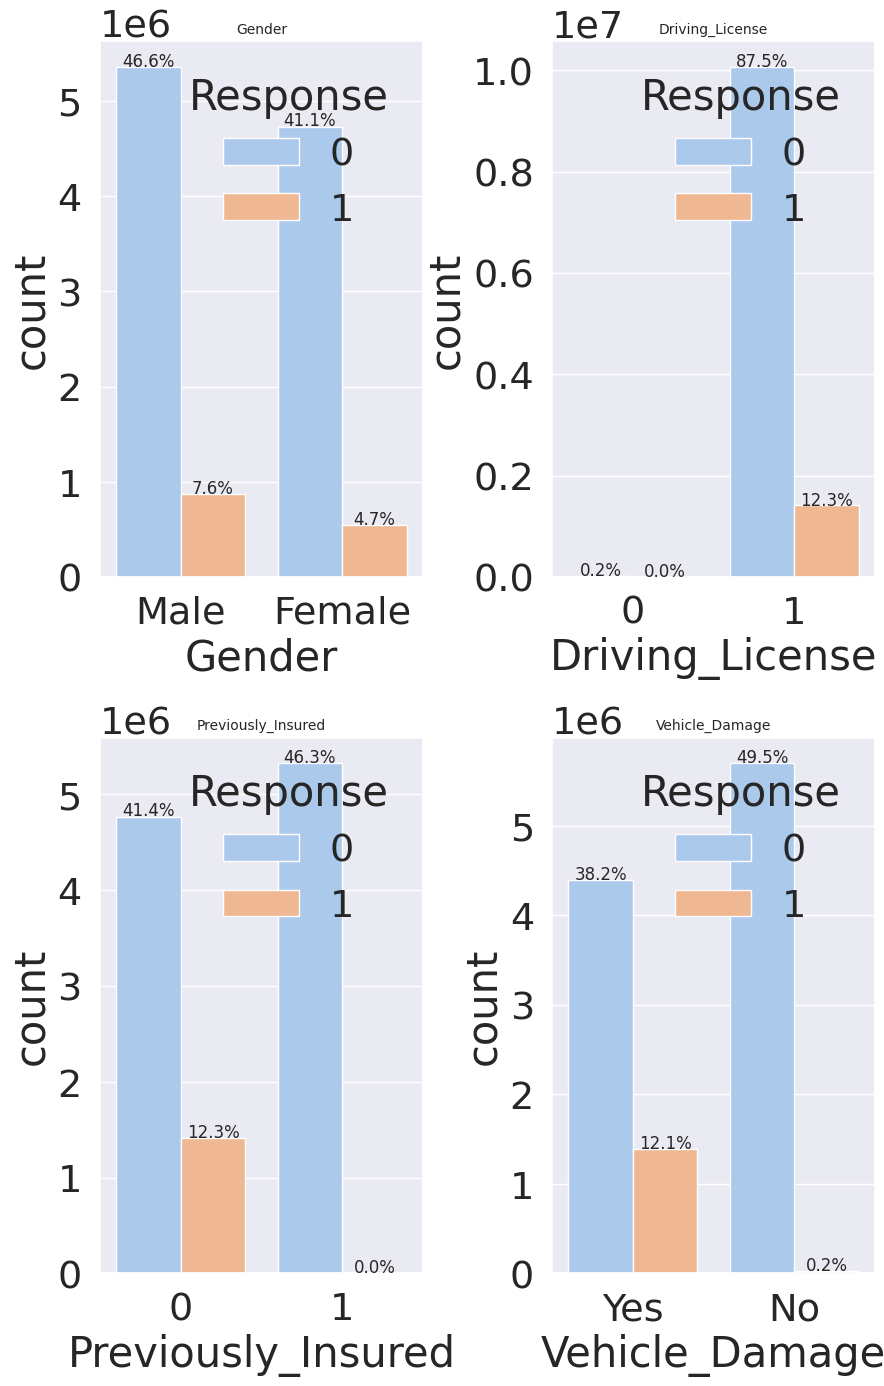

In [34]:
import matplotlib.gridspec as gridspec # 여러 그래프를 격자 형태로 배치

# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=12)
grid = gridspec.GridSpec(2, 2) # 그래프(서브플롯)를 2행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 서브플롯 그리기 Gender , Driving_License, Previously_Insured, Vehicle_Damage
bin_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage'] # 피처 목록

for idx, feature in enumerate(bin_features): 
    ax = plt.subplot(grid[idx]) 
    
    # ax축에 타깃값 분포 카운트플롯 그리기
    sns.countplot(x=feature,
                  data=df_train,
                  hue='Response',
                  palette='pastel', # 그래프 색상 설정
                  ax=ax)
    
    ax.set_title(f'{feature}',fontsize = 10) # 그래프 제목 설정
    write_percent(ax, len(df_train))                     # 비율 표시

In [16]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, 
                                  size=(12, 18)):
    mpl.rc('font', size=9) 
    plt.figure(figsize=size)                     # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        # ax축에 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
        sns.barplot(x=feature, y='Response', data=df, palette='Set2', ax=ax)

In [17]:
bin_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage'] # 이진 피처

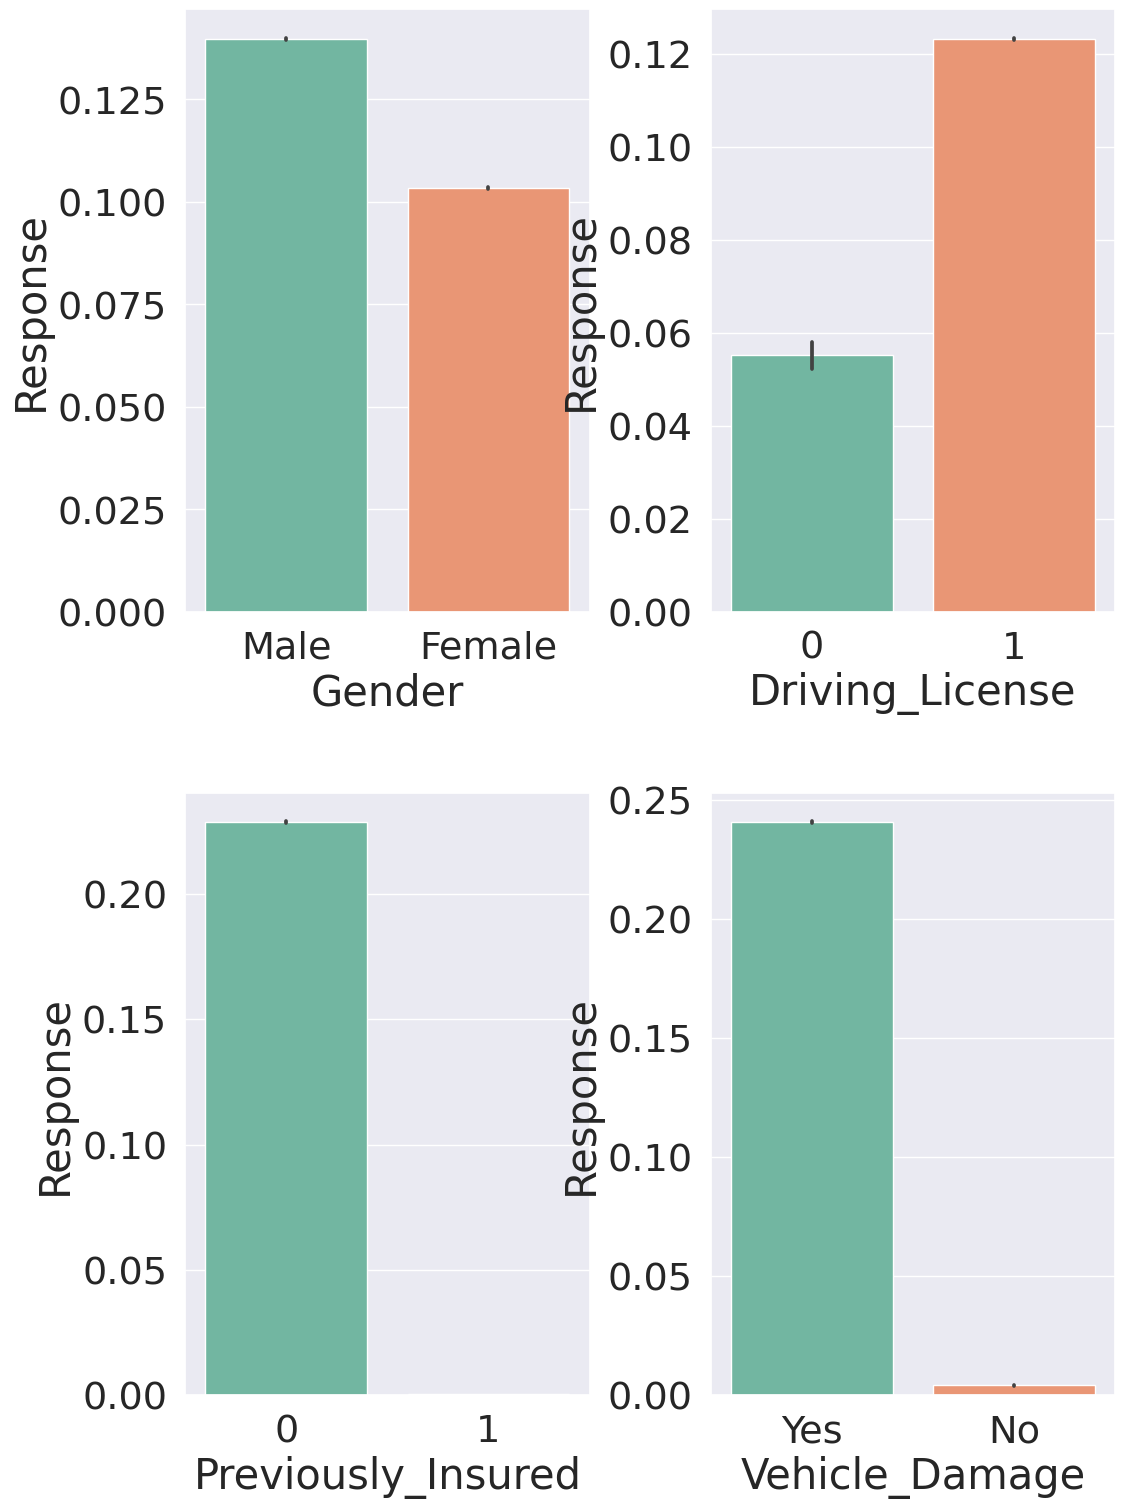

In [18]:
# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(df_train, bin_features, 2, 2) # 2행 2열 배치 ( 출력이 오래걸려서 실행에 유의할 것. )

캐글에서 주최한 대회라그런지 확실히 신뢰구간은 매우 좁았고 대체적으로 모두 고윳값별 비율이 다름.

그나마 Drive 라이센스가 신뢰구간이 크다 생각하지만 저정도는 고윳값 비율이 큰 차이나므로 채용하기 좋아보임.

전체적으로 매우 친절한(?) 데이터들임.

여기서 특이한 점은 Previously_Insured의 경우 한명도 1 즉, 보험에 응답하지 않았다는 사실입니다.

번역하면 "이전_보험 가입"이므로 예전에 보험을 가입했으므로 추가 응답을 하지않을 것이라는 직관적 사고도 가능합니다.

이렇게 많이 차이나는 데이터들은 모델링 예측에 큰 도움이됩니다. 

**해당 그래프들이 타깃값 1 비율을 막대 그래프로 그린것임을 상기하시길 바랍니다.**



### 신뢰구간이 넓어도 피처를 제거하지 않는 경우
특정 값의 신뢰하한과 다른값의 신뢰 상한간의 크기가 큰 경우

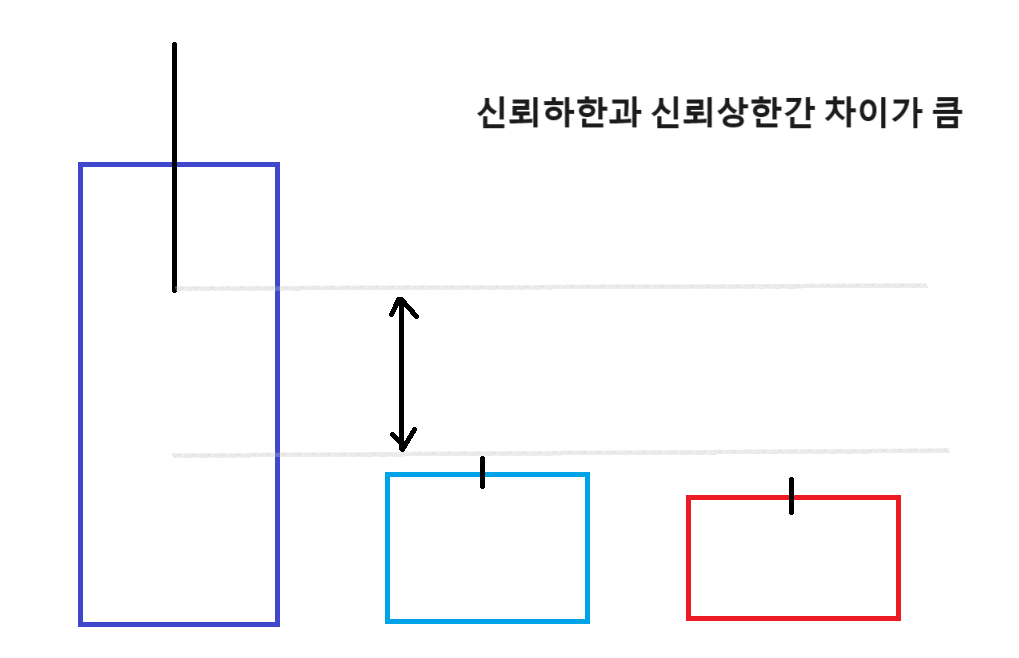

## 범주형 피처 분포 파악
- Region_Code, Vehicle_Age

Region_Code의 경우 너무 많은 고유값을 가지므로 각자 따로 아래에서 한번 더 보긴 할것입니다.

In [19]:
nom_features = ["Region_Code", "Policy_Sales_Channel", "Vehicle_Age"]

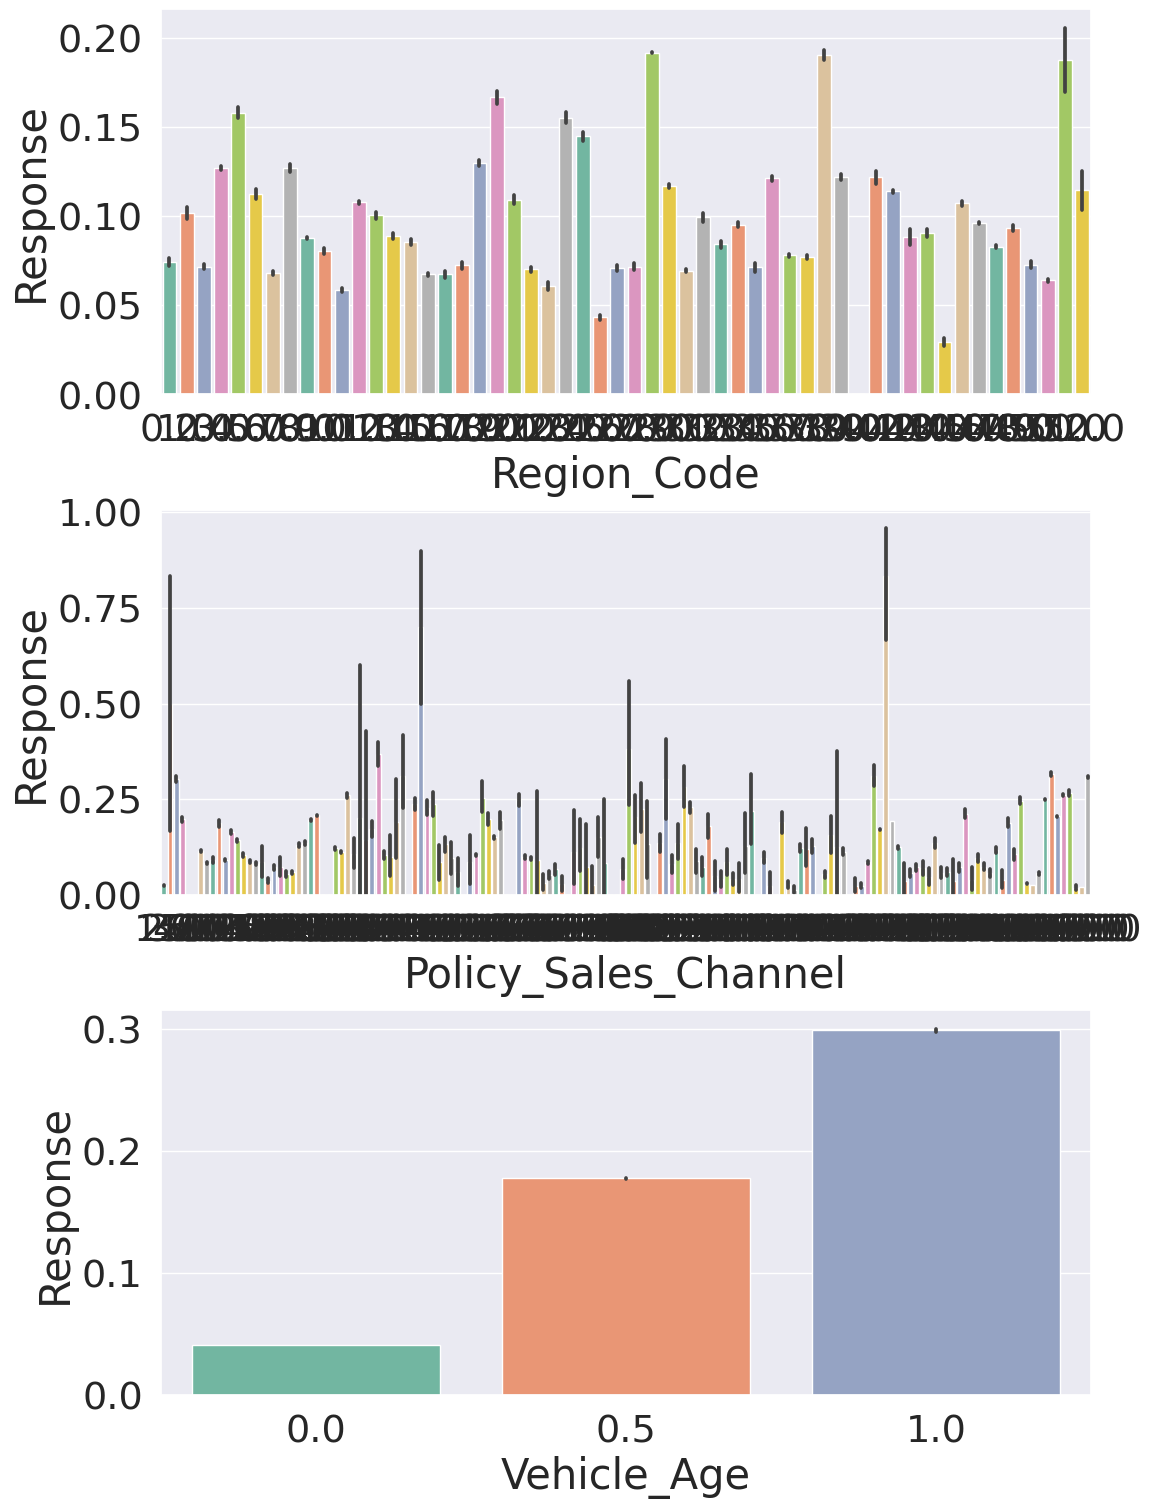

In [67]:
plot_target_ratio_by_features(df_train, ["Region_Code", "Policy_Sales_Channel", "Vehicle_Age"], 3, 1) # 3행 1열 배치 = 고유값이 많은 Regin Code 때문에
# 너무 실행이 오래걸리므로 주석처리 실행에 유의할것

Region_Code의 경우 매우 작은 수치가 하나보이네요.

이후 각 피처별 분석에서 한번 언급할 예정입니다. 직접 데이터를 까보기전, 대략적인 흐름을 볼 수 있습니다.

역시나 신뢰구간이 튀지만 사용할만 한 데이터입니다.

Vehicle Age의 경우 매우 이상적인 데이터이구요.

**참고로 Vehicle Age의 경우 순서형 피처로 변환할 것입니다.**

순서형 피처로써 보았을때, 순서에 따라 1의 확률값이 증가하므로 매우 이상적인 데이터라 볼 수 있습니다.


### 반면 Policy_Sales_Channel의 경우 신뢰구간이 큰 일부 수치가 있습니다.

1이 결정되는데 모델링의 지표가 신뢰 가능한지 확신이 서지 않습니다.

피처를 제거하여 학습을 진행하는 것이 좋은 판단인가? 그렇기엔 다른 타깃값 격차가 큽니다. 그런데 원핫을 또 시키기엔 고유값이 너무 많습니다. 학습을 시키고 성능 비교를 한번 진행해 보겠습니다.

다른 캐글을 분석해본 결과 특정 수치의 신뢰구간이 크더라도 영향이 있는 것으로 판단하여 포함하여 시키는것이 좋다고 하는 예시가 있긴합니다. 
이는 학습 진행한 후 비교를 통해 알아봐야겠습니다. ( 아마 이상적인 친절한 데이터가 많이 포함된 캐글 대회 특성상 포함하는것이 좋으려나? 이런 생각도 들음. )

# 수치형 피처 분포 파악 

( 연속형 -  , 이산형 - Age, Vintage, Annual_Premium  )

- Age, Annual_Premium, Vintage

마지막으로 수치형 피처를 볼 차례입니다.

수치형 피쳐는 고윳값이 굉장히 많습니다. 고윳값별 타깃값 1 비율을 구하기가 힘들겠죠 그렇기 때문에 값을 몇 개의 구간으로 나눠서 구간별 타깃값 1 비율을 알아보겠습니다.

( Tip 고윳값이 아주 많을 때는 몇 개의 구간으로 나눠 구간별 비율을 알아볼 수 있습니다. )

In [20]:
cont_features = ["Age", "Annual_Premium", "Vintage"] # 연속형 피처

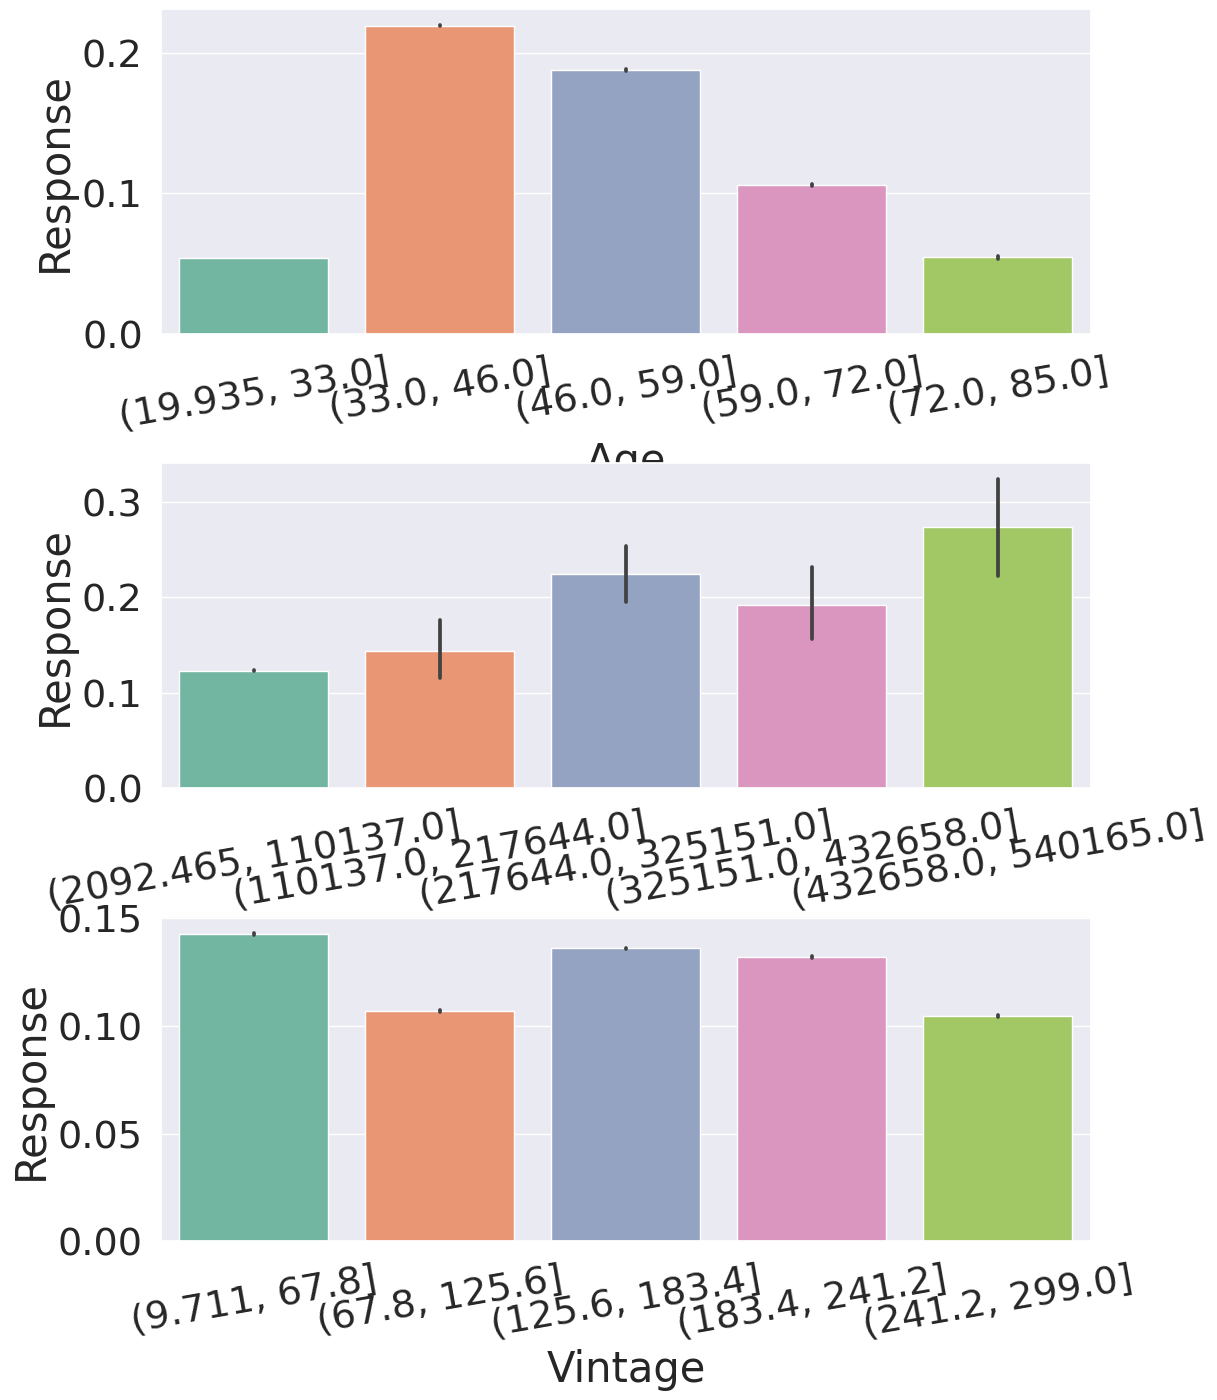

In [40]:
# pd.cut을 통해 분할합니다.

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(3, 1)              # GridSpec 객체 생성. 3개이므로 3,1
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    df_train[cont_feature] = pd.cut(df_train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='Response', data=df_train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

제가 코드를 통해 자료를 시각화 만드는 것이 미숙하다보니 글자가 지워진걸 보이도록 수정은 못했습니다만,

위 에서부터 "Age", "Annual_Premium", "Vintage" 로 보면 될 것 같습니다.

신뢰구간도 작으며 각 고유값 별 Response 확률도 다르므로 모두 채용하면 될 것 같습니다.


# 수치형 피처 분포 파악2

- Age, Annual_Premium, Vintage

다음으로 수치형 피처 간 '상관관계' 를 파악해 보겠습니다. 일반적으로 강한 상관관계를 보이는 두 피처가 있으면 둘 중 하나를 제거하는 게 좋습니다. 상관관계가 강하면 타깃값 예측력도 비슷합니다. 그런 피처가 있으면 모델 성능이 떨어질 수도 있습니다.

( Tip 상관관계가 강한 피처들은 예측력도 비슷하므로 하나만 남겨두는 게 좋습니다. 


## ( 안읽어도 됨. 팁 구성 )
상관관계가 얼마나 강한 피처를 제거해야하는가?

마땅한 기준은 없습니다. 상황과 모델에 따라 다릅니다. 더불어, 강한 상관관계보이는 두 피처중 하나 제거한다고 반드시 성능이 향상되지도 않습니다. "고려해볼만한 요소" 정도로 생각하면 됩니다.

피어슨 상관계수를 참고할 순 있습니다.

> **피어슨 상관 계수( 표 넣는법 모름 )**
>
>0.00~0.19 : 아주 약함
>
>0.20~0.39 : 약함
>
>0.40~0.59 : 보통
>
>0.60~0.79 : 강함
>
>0.80~1.0 : 아주 강함


0.08이상의 아주 강한 상관 관계를 보이는 피처가 있다면 제거 고려도 좋은 방법입니다.

#### 히트맵을 그릴 예정입니다.
보통 히트맵은 결측값이 있으면 올바르지 않은데, 저희 데이터는 결측값이 없습니다.

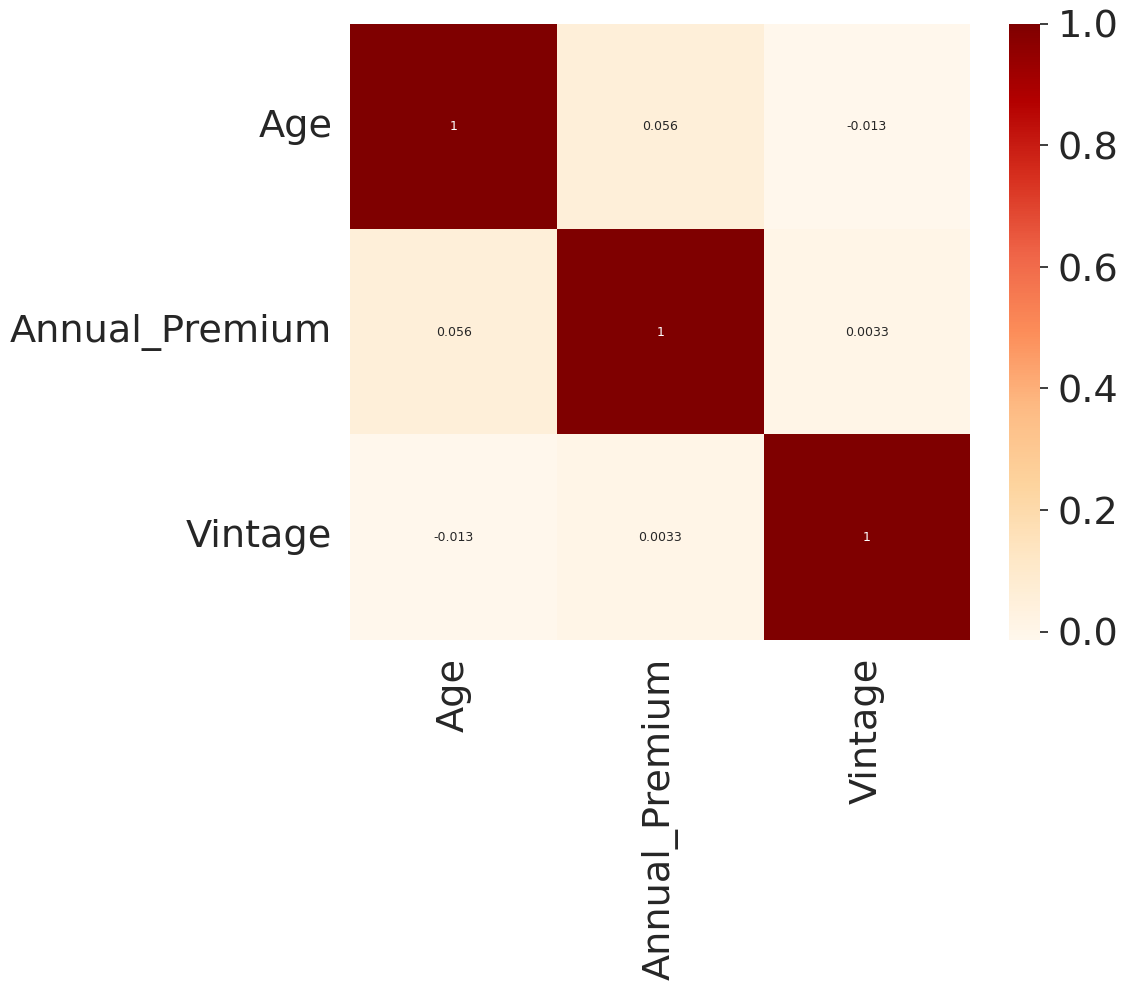

In [41]:
# 참고로 pd.cut() 을 했기 때문에 다시 데이터를 로드한후 해야합니다.
df_train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv") # 바로 요렇게 말이죠.
train_copy = df_train.copy()

plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr()     # 연속형 피처 간 상관관계 
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # 히트맵 그리기

아주 강한 상관관계를 보이는 피처는 없군요. 역시나 제거할 피처는 없습니다!

만약 강한 상관관계가 보인다면 한 피처를 제거하는것을 실험해볼만 합니다.

가령 다른 대회에서는 이야기론 0.77 정도 애매한 수치라 제거 안했다가 제거를 해보니 성능이 향상되기도 했다고합니다.

즉, 여러 실험적 과정이 필요합니다!

# **요약**

"마땅히 버릴 피처는 보이지 않는다." ( 캐글 대회라 그런 것으로 보임 ) 로 요약할 수 있겠습니다.

### 전체적인 구조를 보았으니 각 피처마다 하나하나 피처 엔지니어링을 해보겠습니다.

In [42]:
# 이번 대회에서는 없앨 피처가 없지만 
# 안쓸 항목 제거는 다음 코드를 통해 가능하다.
# df_train.drop(['Region_Code','Age'], axis=1, inplace=True)

# **이진 피쳐**

# Gender - 이진 피쳐

#### 원핫 인코딩? No. 1과 0으로

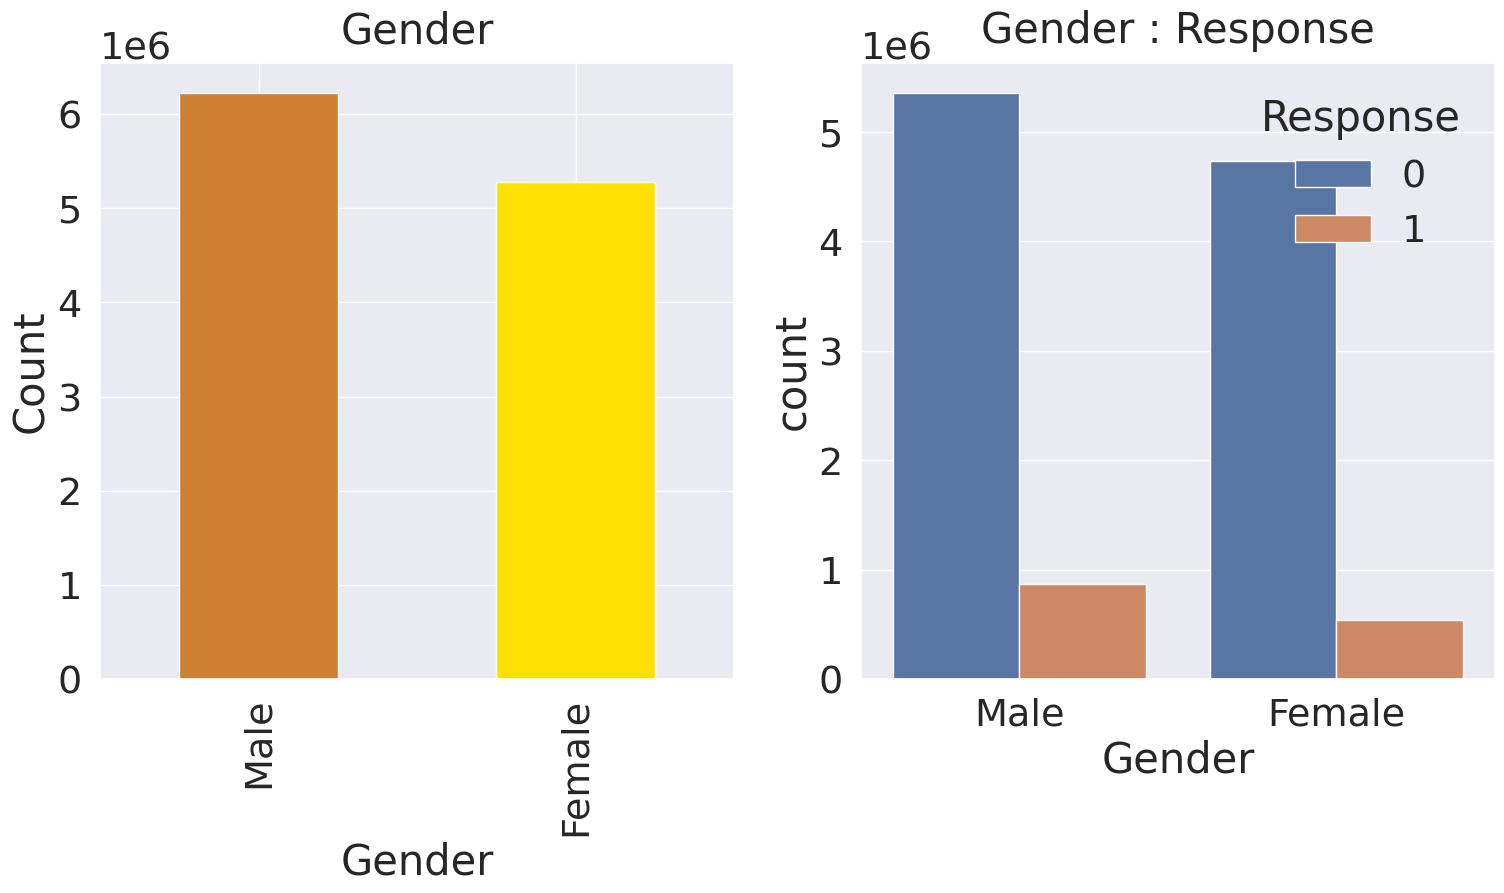

In [43]:
# 클래스 여러개일때 EDA 하기 ( 현 대회는 카테고리 피쳐가 2개 최대. )
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train['Gender'].value_counts().plot.bar(color=['#CD7F32','#FFDF00'], ax=ax[0])
ax[0].set_title('Gender', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot(data=df_train , x='Gender', hue='Response',ax=ax[1]) # countplot 사용법이 달라진듯 합니다.
ax[1].set_title('Gender : Response', y=y_position)
plt.show()

Text(0.5, 1.0, 'df_train Gender')

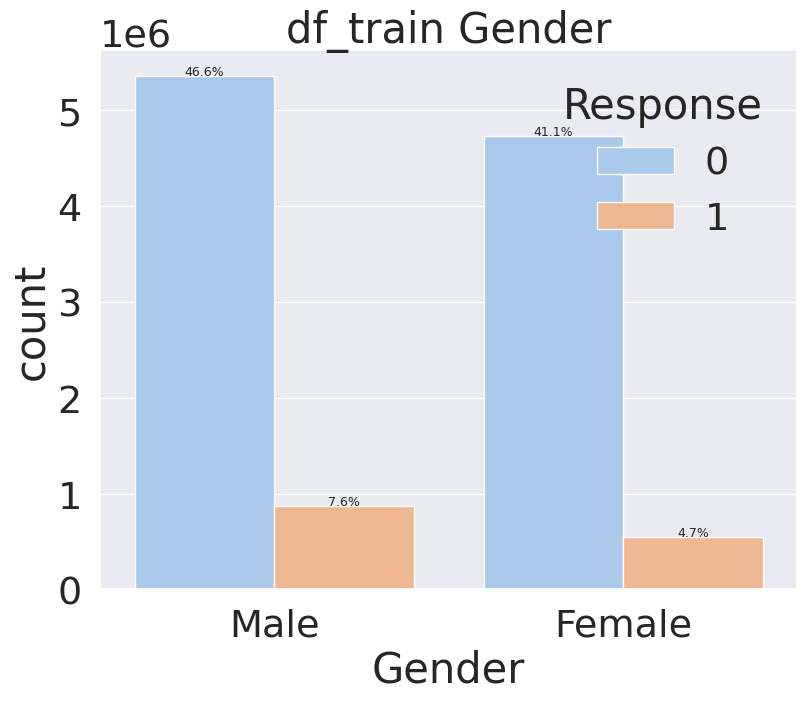

In [44]:
plt.figure(figsize=(9,7))

ax = sns.countplot(x='Gender',
                   data=df_train,
                   hue='Response',
                   palette='pastel' # 그래프 색상
                   )

write_percent(ax, len(df_train)) # 비율 표시
ax.set_title("df_train Gender")

Gender 데이터의 경우에도 비율이 비슷하므로 특정 타깃 값에 치우치지 않다는 것을 확인 가능합니다.

[ 정답이 87%, 12% 정도였으니 비슷한 비율이라 봐도 무방 ] : 이는 위에서는 1의 응답율로 보았습니다.

In [45]:
pd.get_dummies(df_train, columns=["Gender"], prefix="Gender") 

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male
0,0,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,False,True
1,1,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,False,True
2,2,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,True,False
3,3,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,True,False
4,4,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0,False,True
11504794,11504794,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1,True,False
11504795,11504795,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0,True,False
11504796,11504796,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1,True,False


In [46]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


가령 이렇게 One Hot 인코딩 하기도 하는데요.

하지만 이진 데이터의 경우 1과 0으로 하는것이 더 효율이 좋습니다.

관련 정보 기입합니다.

### - ask : 이진 데이터는 pd.get_dummies 를 통해 바로 원핫 인코딩을 하지않고, 왜 1과0으로 바꿔주는식으로 인코딩해?

이진 데이터(binary data)는 본래 0과 1의 값만을 가지므로, `pd.get_dummies`를 사용해 원핫 인코딩(one-hot encoding)을 할 필요가 없습니다. 이 방법은 더 효율적이고, 데이터의 의미를 더 잘 반영할 수 있습니다. 아래에 그 이유를 몇 가지로 나열해보겠습니다:

1. **효율성**: 이진 데이터를 원핫 인코딩하면 불필요하게 열이 늘어납니다. 예를 들어, `pd.get_dummies`를 사용하면 두 개의 열이 생기는데, 이 중 하나는 불필요합니다. 이진 데이터는 이미 0과 1로 잘 표현되고 있어서 추가적인 변환이 필요하지 않습니다.

    ```python
    import pandas as pd
    df = pd.DataFrame({'binary_feature': [0, 1, 0, 1]})
    print(pd.get_dummies(df, columns=['binary_feature']))
    ```

    위 코드는 다음과 같은 결과를 초래합니다:

    ```
       binary_feature_0  binary_feature_1
    0                 1                 0
    1                 0                 1
    2                 1                 0
    3                 0                 1
    ```

    여기서 `binary_feature_0` 열은 `binary_feature_1` 열의 반대 개념으로, 필요하지 않은 정보입니다.

2. **해석의 용이성**: 원핫 인코딩된 이진 데이터는 해석이 더 어렵습니다. 원핫 인코딩된 결과는 실제 데이터의 이진적인 특성을 잘 반영하지 못하고, 데이터가 불필요하게 복잡해집니다.

3. **모델의 효율성**: 대부분의 머신러닝 알고리즘은 이진 데이터를 직접 다루는 것이 더 효율적입니다. 모델에 불필요한 열을 추가하면 연산 복잡도가 증가하고, 모델의 성능에 악영향을 미칠 수 있습니다.

4. **불필요한 메모리 사용**: 원핫 인코딩은 이진 데이터를 다룰 때 메모리 사용량을 증가시킵니다. 데이터셋이 클 경우 이는 큰 문제로 이어질 수 있습니다.

결론적으로, 이진 데이터는 이미 0과 1로 잘 표현되어 있기 때문에 `pd.get_dummies`와 같은 방법을 통해 추가적인 인코딩을 할 필요가 없습니다. 이는 효율성, 해석의 용이성, 모델의 성능 등 여러 측면에서 더 나은 접근법입니다.


이에, 1과 0으로 데이터를 변환해 줍니다.

In [47]:
df_train["Gender"] = df_train["Gender"].map({"Female" : 0, "Male" : 1})
df_test["Gender"] = df_test["Gender"].map({"Female" : 0, "Male" : 1})

In [48]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,1,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,0,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,0,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,0,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


Gender가 0과 1로 변경되었습니다.

# Drivig License, Previously_Insured - 이진 피쳐

이는 이미 0과 1로 되어있는 데이터입니다.

전처리는 하지않고 간단히 자료만 보겠습니다.

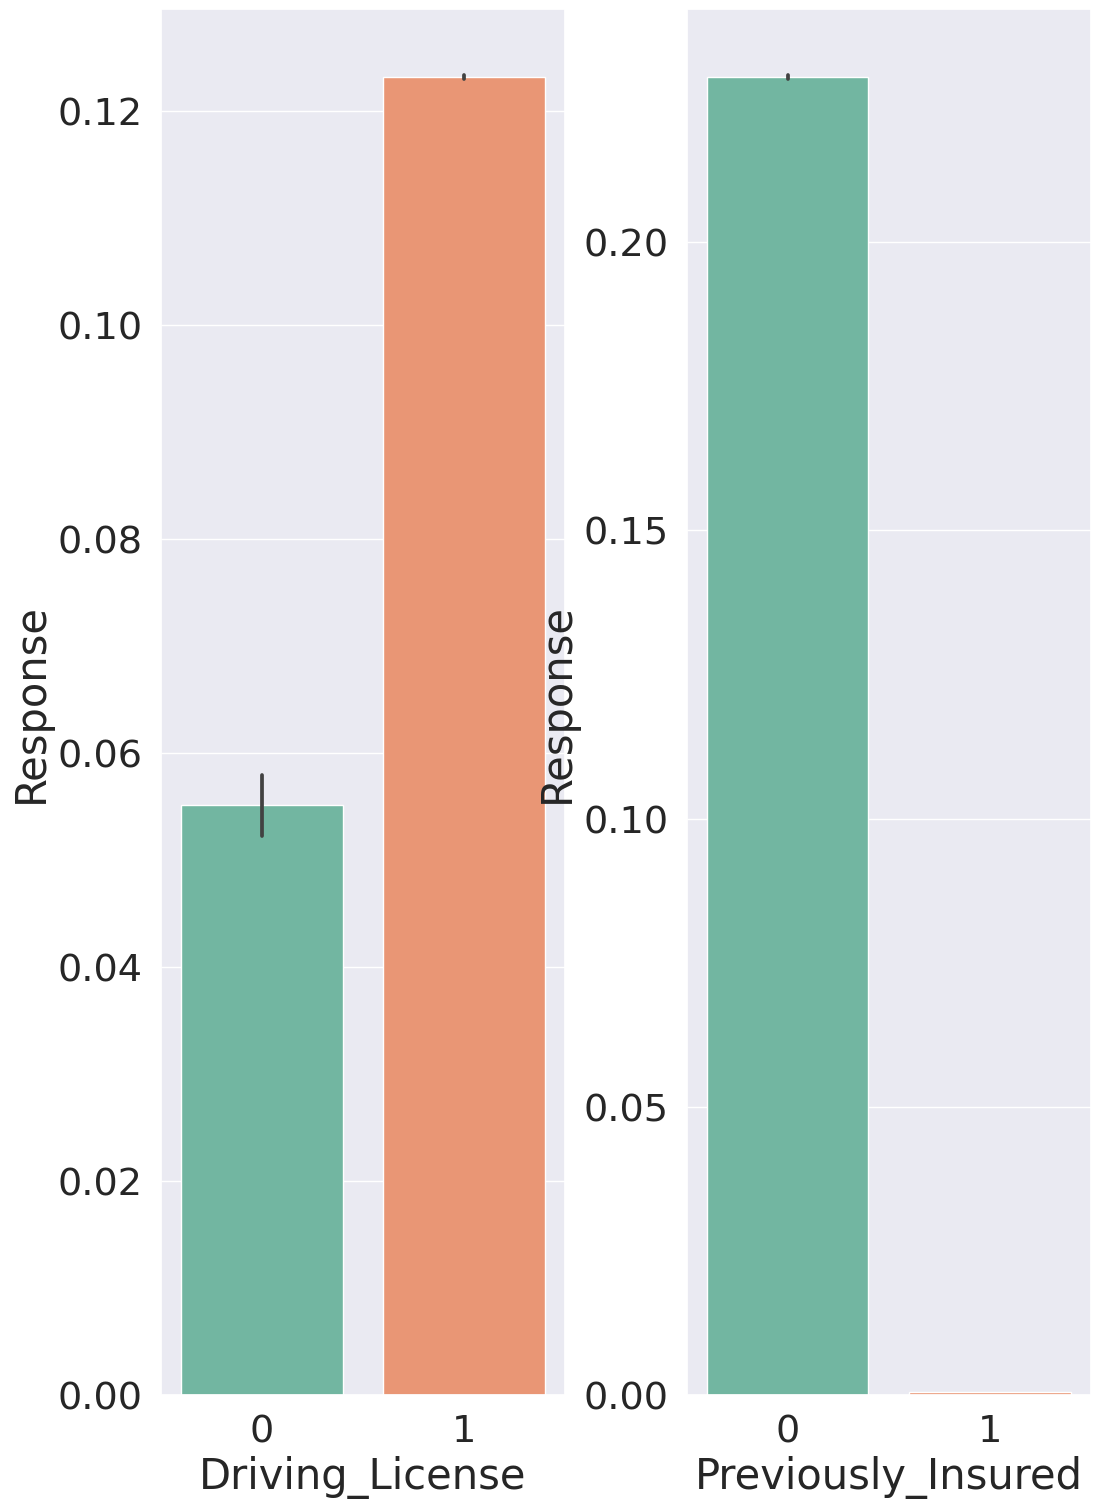

In [49]:
plot_target_ratio_by_features(df_train, ['Driving_License','Previously_Insured'], 1, 2)

# Vehicle_Damage - 이진 피쳐

마지막으로 Gender와 같은 방식으로 전처리 진행하겠습니다.

In [50]:
df_train["Vehicle_Damage"] = df_train["Vehicle_Damage"].map({"No" : 0, "Yes" : 1})
df_test["Vehicle_Damage"] = df_test["Vehicle_Damage"].map({"No" : 0, "Yes" : 1})
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35.0,0,1-2 Year,1,65101.0,124.0,187,0
1,1,1,43,1,28.0,0,> 2 Years,1,58911.0,26.0,288,1
2,2,0,25,1,14.0,1,< 1 Year,0,38043.0,152.0,254,0
3,3,0,35,1,1.0,0,1-2 Year,1,2630.0,156.0,76,0
4,4,0,36,1,15.0,1,1-2 Year,0,31951.0,152.0,294,0


# **범주형 피처**

범주형 데이터는 명목형, 순서형으로 나뉩니다.

# Region_Code - 명목형 피처

위에서 보았듯 뭔가 이상치가 있다는 것을 직관적으로 알 수 있습니다.

이를 제거하고, One Hot 인코딩을 해보겠습니다.

사실 One Hot 으로 하기엔 너무 많다고 판단하여 ( 데이터가 많아서 학습이 느려지므로 ) 타깃 인코딩, 프리퀀시 인코딩을 찾아서 적절한 것을 골라보려했으나. 

일단 One Hot 으로 진행하려 합니다.

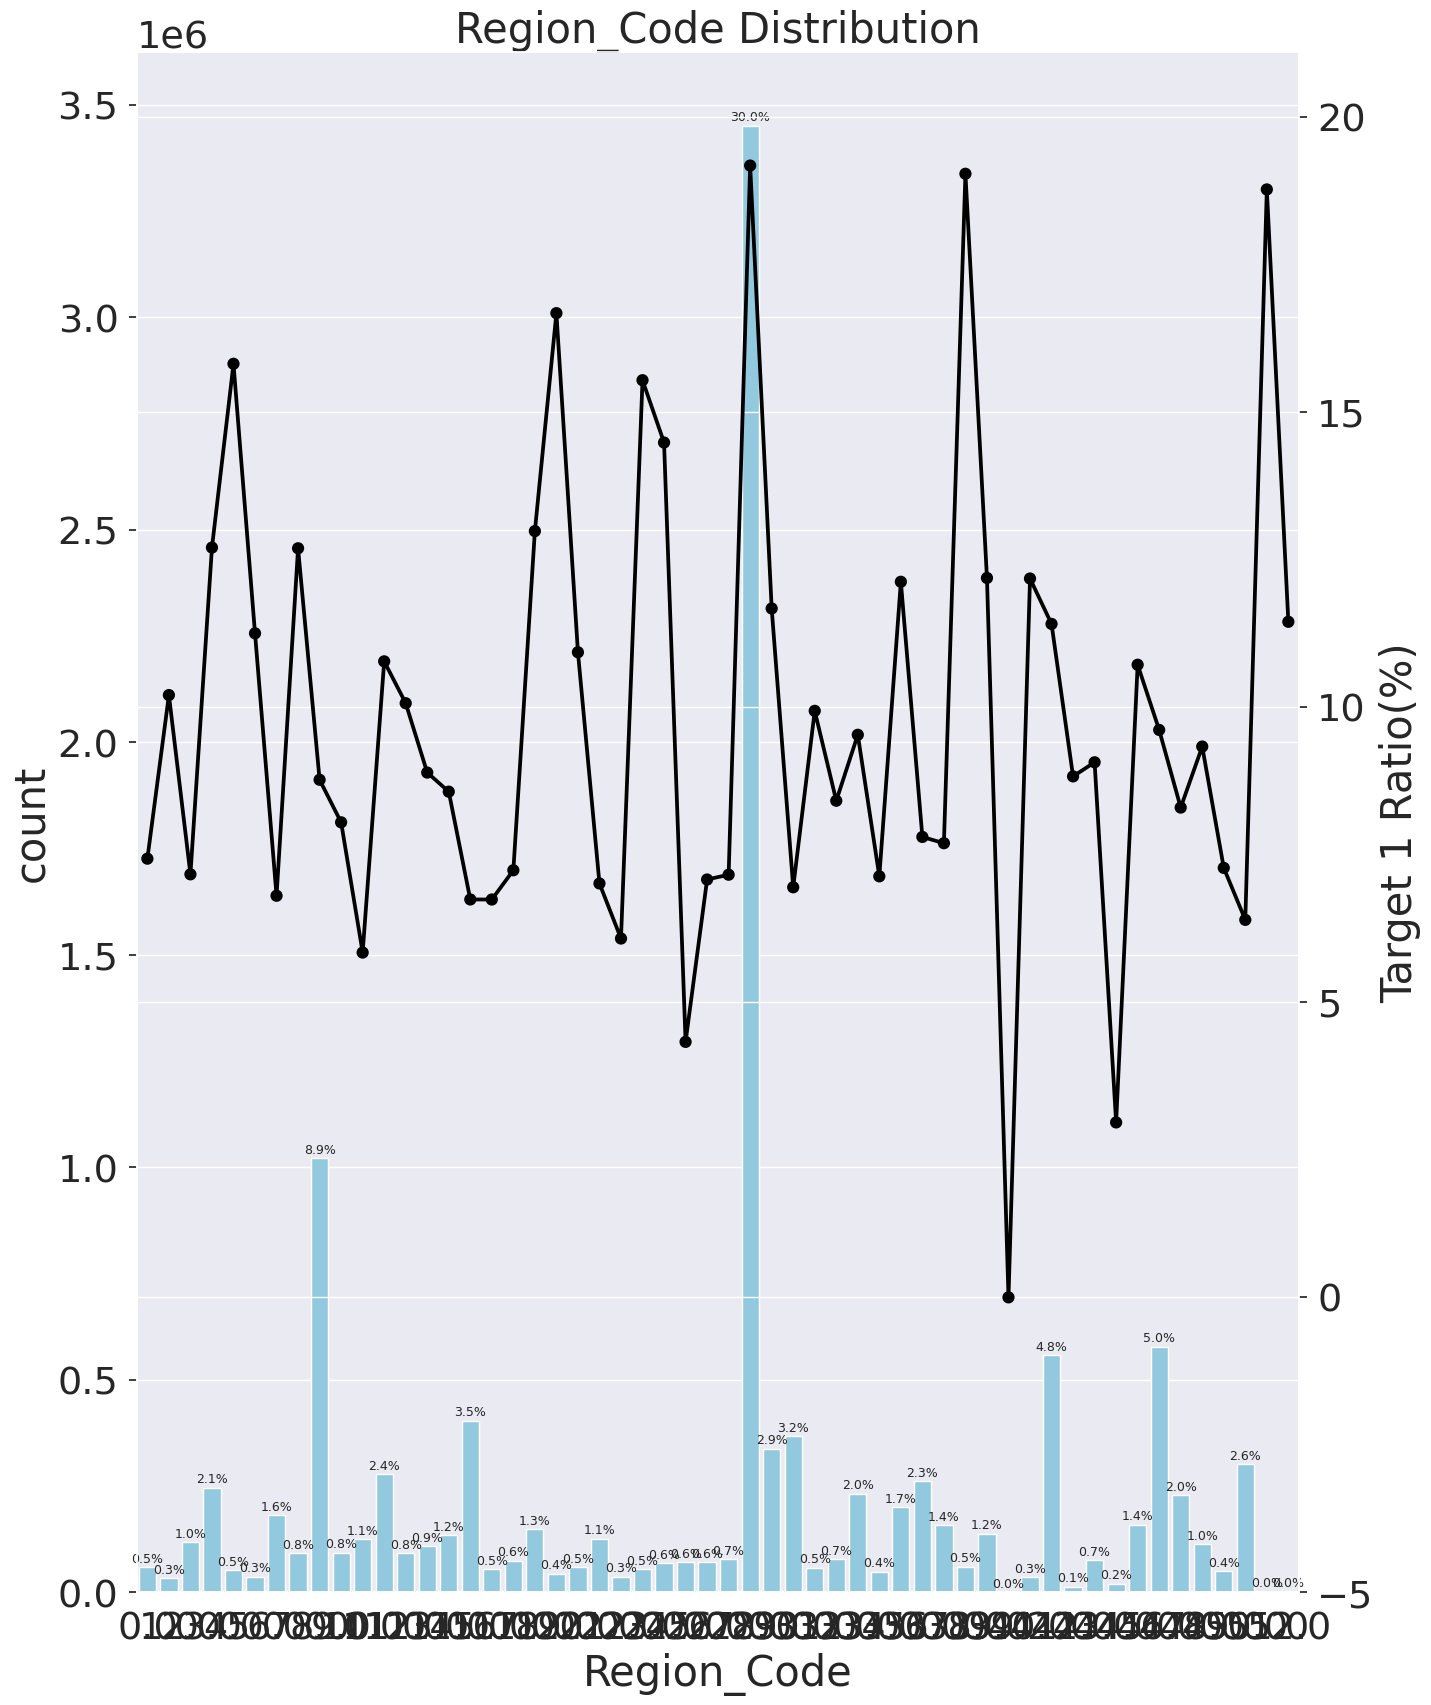

In [68]:
nom_features = ['Region_Code'] # 명목형 피처
plot_cat_dist_with_true_ratio(df_train, nom_features, num_rows=1, num_cols=1)

#### Region_Codee는 각 고유값 .... 이며 해당 선 그래프는 Response가 1인 확률을 의미합니다.
#### 각 고윳값 별로 타깃값 1의 비율이 서로 다릅니다. 즉, 타깃값에 대한 예측능력이있음을 뜻합니다.

In [69]:
df_train['Region_Code'].unique()

array([35. , 28. , 14. ,  1. , 15. , 47. , 45. ,  8. , 11. ,  3. , 10. ,
       12. , 37. , 50. , 30. , 46. , 29. , 16. , 26. , 25. , 41. , 48. ,
        7. ,  4. , 24. , 36. , 33. ,  2. ,  9. , 27. , 18. , 43. , 49. ,
       17. , 13. , 38. ,  6. , 21. , 23. ,  0. , 19. ,  5. , 39. , 44. ,
       20. , 40. , 22. , 32. , 42. , 31. , 34. , 51. , 52. , 39.2])

In [70]:
df_train['Region_Code'].value_counts()

Region_Code
28.0    3451062
8.0     1021036
46.0     578208
41.0     557581
15.0     403977
30.0     367307
29.0     338146
50.0     302334
11.0     278261
36.0     261946
3.0      246303
33.0     232387
47.0     229190
35.0     200035
6.0      181122
45.0     159292
37.0     158976
18.0     148548
39.0     138068
14.0     134585
21.0     126793
10.0     126081
2.0      118097
48.0     114230
13.0     108838
9.0       93371
7.0       92240
12.0      92142
27.0      78878
32.0      78797
43.0      75868
17.0      74533
26.0      71228
25.0      70556
24.0      69136
38.0      60587
0.0       59274
20.0      58765
31.0      58442
16.0      54905
23.0      54518
4.0       52504
49.0      50822
34.0      48685
19.0      44197
22.0      36932
5.0       36832
40.0      35888
1.0       33966
44.0      20305
42.0      13693
52.0       3450
51.0       1880
39.2          1
Name: count, dtype: int64

In [70]:
df_train['Region_Code'].value_counts()

Region_Code
28.0    3451062
8.0     1021036
46.0     578208
41.0     557581
15.0     403977
30.0     367307
29.0     338146
50.0     302334
11.0     278261
36.0     261946
3.0      246303
33.0     232387
47.0     229190
35.0     200035
6.0      181122
45.0     159292
37.0     158976
18.0     148548
39.0     138068
14.0     134585
21.0     126793
10.0     126081
2.0      118097
48.0     114230
13.0     108838
9.0       93371
7.0       92240
12.0      92142
27.0      78878
32.0      78797
43.0      75868
17.0      74533
26.0      71228
25.0      70556
24.0      69136
38.0      60587
0.0       59274
20.0      58765
31.0      58442
16.0      54905
23.0      54518
4.0       52504
49.0      50822
34.0      48685
19.0      44197
22.0      36932
5.0       36832
40.0      35888
1.0       33966
44.0      20305
42.0      13693
52.0       3450
51.0       1880
39.2          1
Name: count, dtype: int64

In [71]:
df_test['Region_Code'].value_counts()

Region_Code
28.0    2299652
8.0      681778
46.0     386147
41.0     372203
15.0     268477
30.0     244864
29.0     224596
50.0     201968
11.0     184821
36.0     174967
3.0      164427
33.0     155735
47.0     152803
35.0     133825
6.0      120975
45.0     105868
37.0     105620
18.0      99023
39.0      91993
14.0      90023
21.0      84503
10.0      83607
2.0       78461
48.0      76381
13.0      72542
9.0       62304
7.0       61745
12.0      61717
32.0      52787
27.0      52315
43.0      50970
17.0      49492
26.0      47810
25.0      46793
24.0      46316
38.0      40562
0.0       39320
31.0      39143
20.0      38648
16.0      36905
23.0      36176
4.0       34954
49.0      34036
34.0      32328
19.0      29253
22.0      24443
5.0       24220
40.0      23831
1.0       22359
44.0      13583
42.0       9042
52.0       2295
51.0       1260
Name: count, dtype: int64

In [72]:
train_unique = set(df_train['Region_Code'].unique())
test_unique = set(df_test['Region_Code'].unique())

print("Train Data Unique Region Codes:", train_unique)
print()

print("Test Data Unique Region Codes:", test_unique)
print()

unique_difference = train_unique.symmetric_difference(test_unique)
print("Unique Region Codes not shared between train and test:", unique_difference)

Train Data Unique Region Codes: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 39.2}

Test Data Unique Region Codes: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0}

Unique Region Codes not shared between train and test: {39.2}


즉, 39.2는 없애도될 이상치로 판단이됩니다.

In [73]:
df_train = df_train[df_train['Region_Code'] != 39.2]

In [74]:
train_unique = set(df_train['Region_Code'].unique())
test_unique = set(df_test['Region_Code'].unique())

print("Train Data Unique Region Codes:", train_unique)
print()

print("Test Data Unique Region Codes:", test_unique)
print()

unique_difference = train_unique.symmetric_difference(test_unique)
print("Unique Region Codes not shared between train and test:", unique_difference)

Train Data Unique Region Codes: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0}

Test Data Unique Region Codes: {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0}

Unique Region Codes not shared between train and test: set()


In [75]:
#1. pd에있는 더미스로 원핫 인코딩

df_train = pd.get_dummies(df_train, columns=["Region_Code"], prefix="Region_Code",dtype=int)
df_test = pd.get_dummies(df_test, columns=["Region_Code"], prefix="Region_Code",dtype=int)

In [76]:
# # sklearn을 통한 원핫인코딩 
# from sklearn.preprocessing import OneHotEncoder

# onehot_encoder = OneHotEncoder() # 원 핫 인코더 객체 생성

# # 인코딩
# encoded_ = onehot_encoder.fit_transform(df_train["Region_Code"])

# Policy_Sales_Channel - 명목형 피처

In [77]:
train_unique = set(df_train['Policy_Sales_Channel'].unique())
test_unique = set(df_test['Policy_Sales_Channel'].unique())

print("Train Data Unique Policy_Sales_Channel:", train_unique)
print()

print("Test Data Unique Policy_Sales_Channel:", test_unique)
print()

unique_difference = train_unique.symmetric_difference(test_unique)
print("Unique Policy_Sales_Channel not shared between train and test:", unique_difference)

Train Data Unique Policy_Sales_Channel: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 73.0, 74.0, 75.0, 76.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 145.0, 146.0, 147.0, 148.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 163.0}

In [78]:
df_train[df_train['Policy_Sales_Channel'] == 5.0].shape[0]

1

In [79]:
df_train[df_train['Policy_Sales_Channel'] == 6.0].shape[0]

1

In [80]:
df_train[df_train['Policy_Sales_Channel'] == 33.0].shape[0]

5

In [81]:
df_test[df_test['Policy_Sales_Channel'] == 144.0].shape[0]

1

In [82]:
df_test[df_test['Policy_Sales_Channel'] == 149.0].shape[0]

2

조금 무식하긴하지만 일일이 하나하나 확인하며 해당 피처들도 역시 모두 삭제할만하다는것을 깨달았습니다.

저희는 데이터가 매우 많으므로 한두개는 괜찮습니다! 오히려 성능 향상이 기대되리라 생각하여 삭제합니다. ( 이상치 제거 )

In [ ]:
df_train = df_train[df_train['Policy_Sales_Channel'] != 5.0]
df_train = df_train[df_train['Policy_Sales_Channel'] != 6.0]
df_train = df_train[df_train['Policy_Sales_Channel'] != 33.0]
df_test = df_test[df_test['Policy_Sales_Channel'] != 144.0]
df_test = df_test[df_test['Policy_Sales_Channel'] != 149.0]

In [ ]:
df_train

그 이후 동일하게 one hot 인코딩

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Policy_Sales_Channel'], prefix='Policy_Sales_Channel',dtype=int)
df_test = pd.get_dummies(df_test, columns=['Policy_Sales_Channel'], prefix='Policy_Sales_Channel',dtype=int)

# Vehicle_Age - 순서형 피처

해당 피처는 범주형이며 순서형으로 나타낼 수 있습니다.

위에서 한번 그래프로 보았듯, 정렬에 따라 Response 값이 달라짐을 알 수 있습니다.

- 피처 스케일링이란 서로 다른 피처들의 값 범위가 일치하도록 조정하는 작업. 우리의 경우 1과0으로 이진,명목형 변환하므로 순서형도 0~1이 되도록 스케일링 > Min-Max 스케일링
- 참고 ) 트리 기반 모델(랜덤 포레스트, XGBoost, LightGBM 등)은 피처 스켈링이 필요 없습니다. 트리 기반 모델은 데이터의 크기보다는 대소 관계에 영향을 받기 때문입니다. 피처 스켈링을 하더라도 데이터의 대소 관계에는 변함이 없습니다. 하지만 저희는 딥러닝도 할것이기에 미리 진행해둡니다.

In [53]:
pd.crosstab(df_train["Vehicle_Age"],df_train["Response"])

Response,0,1
Vehicle_Age,,
1-2 Year,4919406,1063272
< 1 Year,4835296,208849
> 2 Years,335037,142938


In [54]:
# 정규화 후 비율을 백분율로 표현
crosstab = pd.crosstab(df_train["Vehicle_Age"],df_train["Response"],normalize='index')*100
crosstab 

Response,0,1
Vehicle_Age,,
1-2 Year,82.227491,17.772509
< 1 Year,95.859576,4.140424
> 2 Years,70.095089,29.904911


In [55]:
crosstab = crosstab.reset_index() #인덱스 재설정 그리기 좋기위해
crosstab

Response,Vehicle_Age,0,1
0,1-2 Year,82.227491,17.772509
1,< 1 Year,95.859576,4.140424
2,> 2 Years,70.095089,29.904911


In [56]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['Response'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

In [57]:
crosstab = get_crosstab(df_train, 'Vehicle_Age')
crosstab

Response,Vehicle_Age,0,1
0,1-2 Year,82.227491,17.772509
1,< 1 Year,95.859576,4.140424
2,> 2 Years,70.095089,29.904911


In [58]:
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab,
                        order=crosstab[feature].values, # 포인트플롯 순서
                        color='black'                  # 포인트플롯 색상
                        )                   # 범례 미표시
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1) # y축 범위 설정
    ax2.set_ylabel('Target 1 Ratio(%)')

In [59]:
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, 
                                  size=(15, 20)):
    plt.figure(figsize=size)  # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.3) # 서브플롯 좌우/상하 여백 설정
    
    for idx, feature in enumerate(features): 
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차분석표 생성

        # ax축에 타깃값 분포 카운트플롯 그리기
        sns.countplot(x=feature, data=df,
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)

        write_percent(ax, len(df)) # 비율 표시
       
        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기
        
        ax.set_title(f'{feature} Distribution') # 그래프 제목 설정

In [60]:
df_train["Vehicle_Age"].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [61]:
# 순서형 데이터므로 각 피처의 순서를 재지정함.
from pandas.api.types import CategoricalDtype 

Vehicle_Age_value = ['< 1 Year','1-2 Year', '> 2 Years']

# 순서를 지정한 범주형 데이터 타입
Vehicle_Age_dtype = CategoricalDtype(categories=Vehicle_Age_value, ordered=True)

# 데이터 타입 변경
df_train['Vehicle_Age'] = df_train['Vehicle_Age'].astype(Vehicle_Age_dtype)

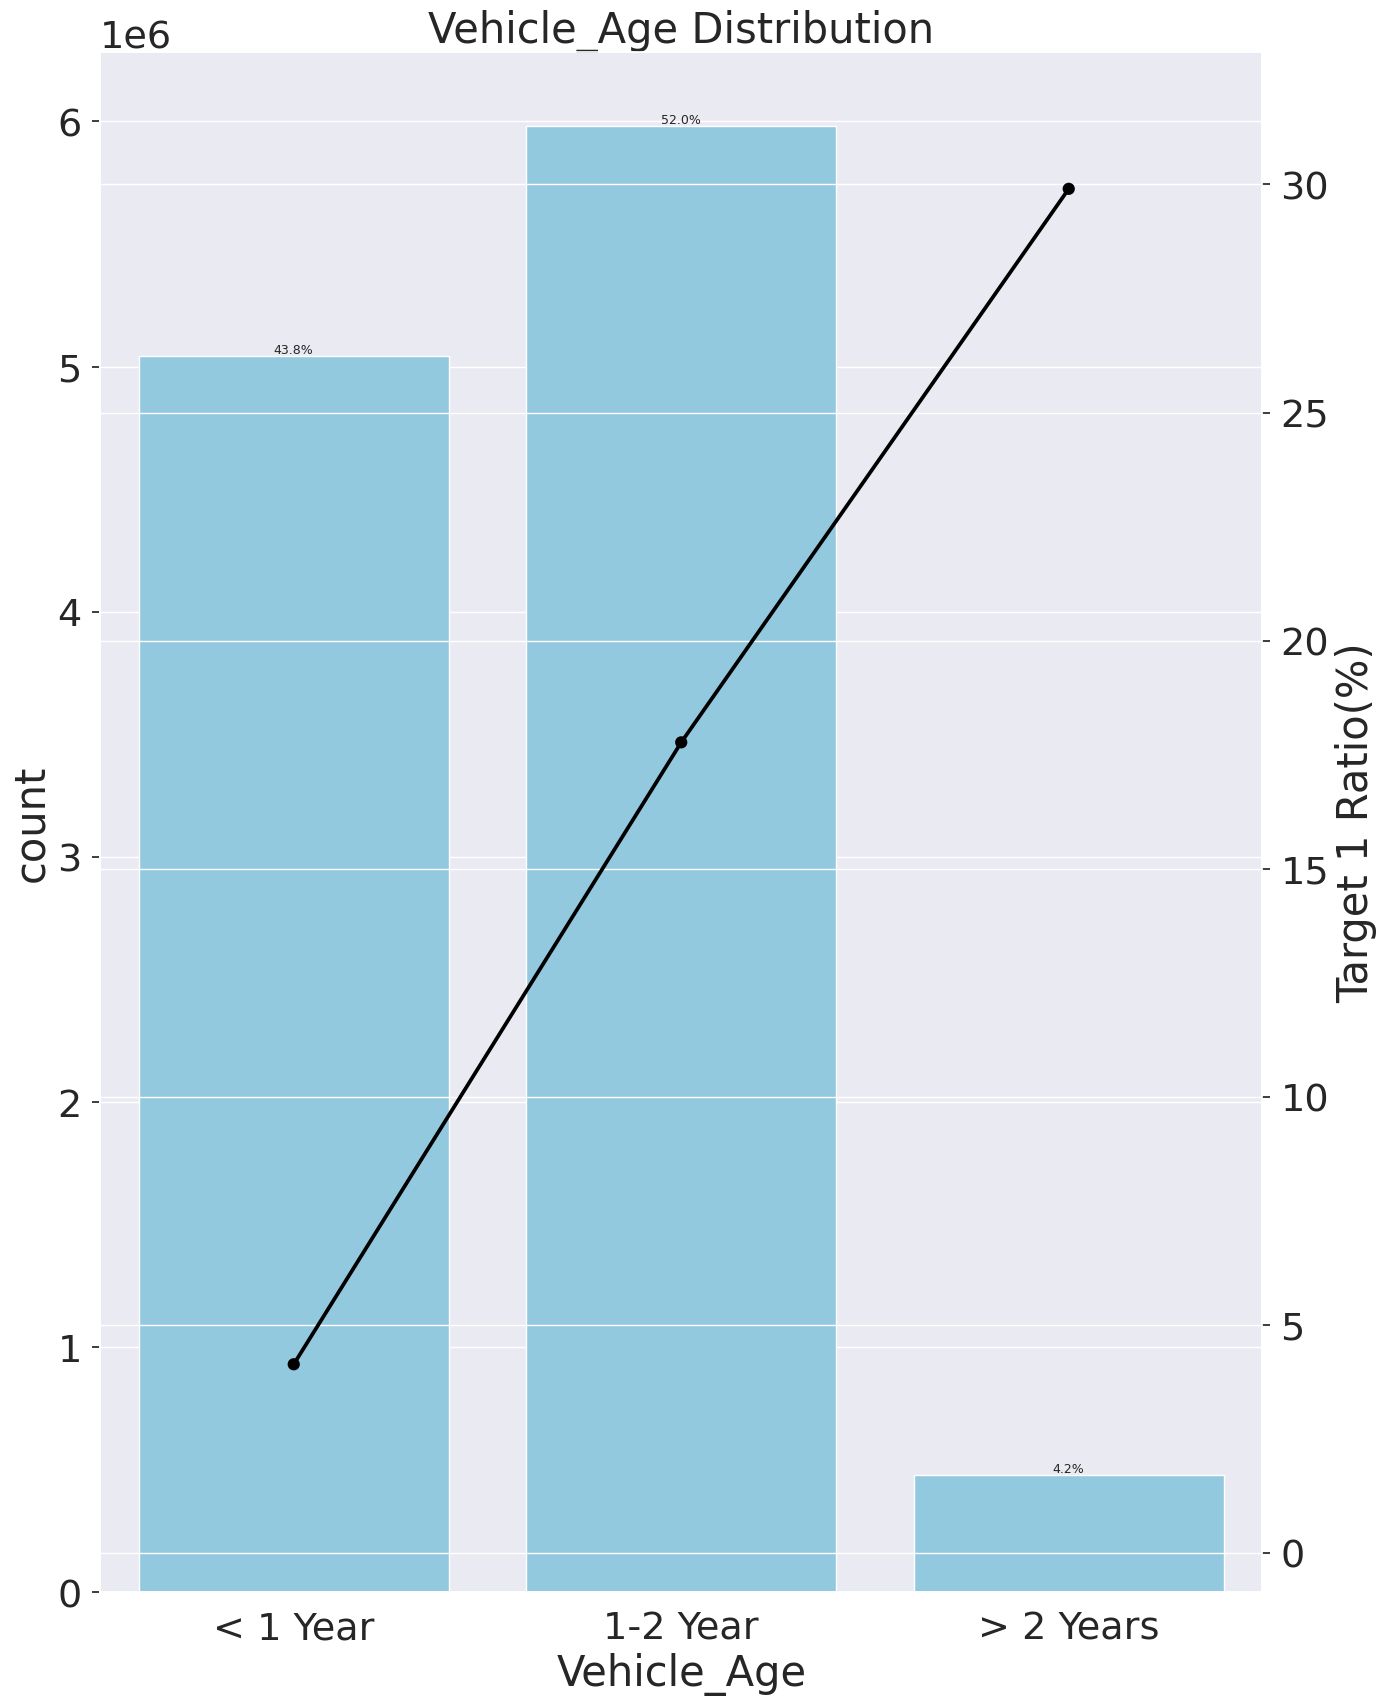

In [62]:
nom_features = ['Vehicle_Age'] # 명목형 피처
plot_cat_dist_with_true_ratio(df_train, nom_features, num_rows=1, num_cols=1)

#### Vehicle_Age는 각 고유값이 1-2 Year, .... 이며 해당 선 그래프는 Response가 1인 확률을 의미합니다.
#### 각 고윳값 별로 타깃값 1의 비율이 서로 다릅니다. 즉, 타깃값에 대한 예측능력이있음을 뜻합니다.
#### 데이터 자료를 보면 순서형 명목 데이터 타입을 쓰기에 마땅한 비율을 보입니다 ( 좌에서 우로 커짐 

그럼 라벨링을 변화시키겠습니다.

In [63]:
df_train["Vehicle_Age"].unique()

['1-2 Year', '> 2 Years', '< 1 Year']
Categories (3, object): ['< 1 Year' < '1-2 Year' < '> 2 Years']

In [64]:
df_train["Vehicle_Age"] = df_train["Vehicle_Age"].map({'< 1 Year' : 0, '1-2 Year' : 0.5 , '> 2 Years':1})
df_test["Vehicle_Age"] = df_test["Vehicle_Age"].map({'< 1 Year' : 0, '1-2 Year' : 0.5 , '> 2 Years':1})

# 수치형 피처

이번 대회에서는 이산형밖에 없다고 판단됩니다. 
- "Age", "Annual_Premium", "Vintage"


# Age

먼저 대략적인 분포 등을 확인하겠습니다.

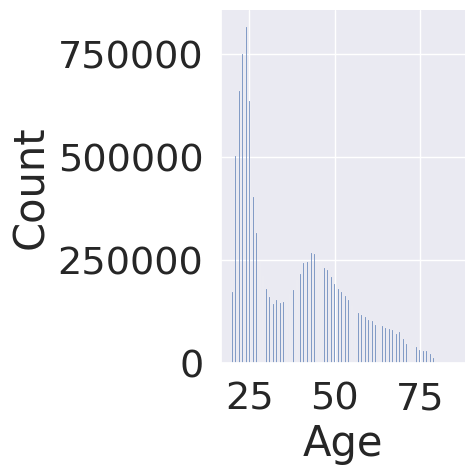

In [22]:
mpl.rc('font', size=15) # 폰트 크기 조절
sns.displot(df_train["Age"]) # 분포도 출력 # 정규화 하자!

<Axes: xlabel='Age'>

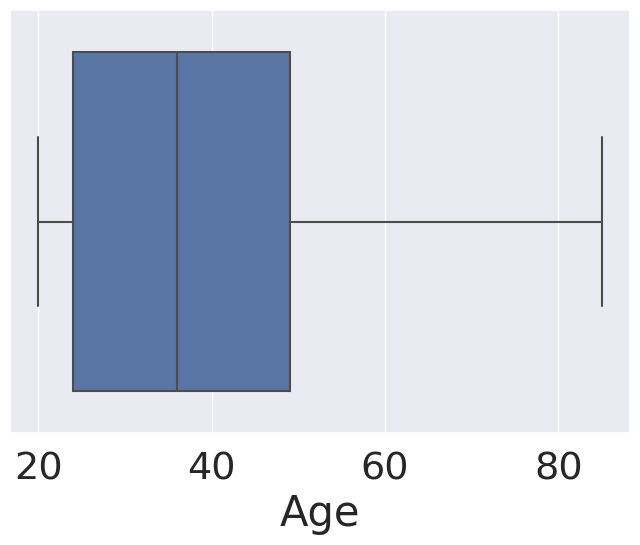

In [21]:
sns.boxplot(x=df_train['Age'])

위에서 오버뷰에서 보았듯이 Age는 신뢰구간이 그렇게 크지 않아서 막 엉청난 이상치는 없습니다.

그러나, 데이터가 한쪽으로 쏠려있습니다. 이를 정규분포에 가깝게 만들기 위해 로그변환을 하겠습니다.이는 test 데이터도 동일합니다.

데이터 분포를 정규분포에 가깝게 만들기 위해 가장 많이 사용하는 방법은 로그변환입니다. 로그변환은 데이터가 왼 쪽에 편향되어있을때 사용합니다.

로그변환 : 이상치의 영향을 줄이고 분포를 정규화하는 데 유용합니다.



**피처 스켈링은 크게 두가지 1. Min-Max , 2. 표준화**

1. Min-Max 는 0과 1사이로만들어줍니다 
2. 표준화는 평균이 0, 분산이 1이되도록 피처값을 조정하는 기법입니다. - 상한과 하한이 없으며 정규분포를 따르는 데이터는 표준화 스케일링을 적용하는 것이 좋습니다.




----
참고 )
보통은 이 둘을 동시에 활용하지않으나, 한번 성능을 위해 시도해볼 법 합니다.

딥러닝 모델의 안정성: 딥러닝 모델에서는 입력 데이터의 스케일이 중요합니다. 표준화를 통해 분포를 정규화한 후, 정규화를 통해 입력 범위를 [0, 1]로 맞추면 학습이 안정적일 수 있습니다.

*해당 부분은 시행착오를 해보고 점수 비교를 해볼 생각입니다.*

먼저 로그 변환을 적용한 그래프를 보겠습니다.

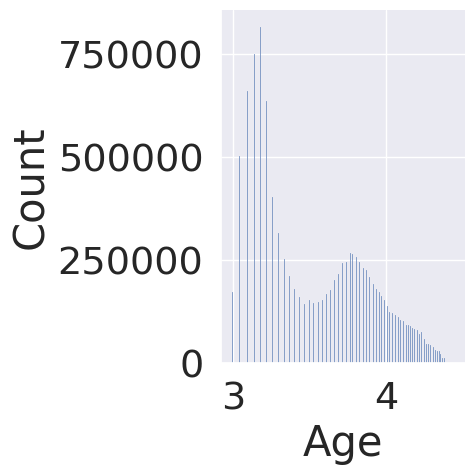

In [23]:
sns.displot(np.log(df_train["Age"]))

상대적으로 정규 분포에 가까워 졌습니다.

그러나 정규분포로 보기엔 어려워보이므로 Min Max 스케일링을 하겠습니다.


In [ ]:
df_train['Age'] = np.log1p(df_train['Age']) # 로그변환
df_test['Age'] = np.log1p(df_test['Age']) # 로그변환

In [ ]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

df_train['Age'] = scaler.fit_transform(df_train[['Age']])
df_test['Age'] = scaler.fit_transform(df_test[['Age']])

In [ ]:
sns.displot(df_train["Age"]) # 분포도 출력

# Annual_Premium

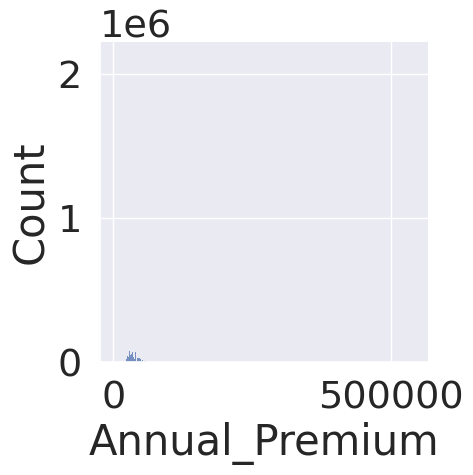

In [25]:
mpl.rc('font', size=15) 
sns.displot(df_train["Annual_Premium"]) 

<Axes: xlabel='Annual_Premium', ylabel='Density'>

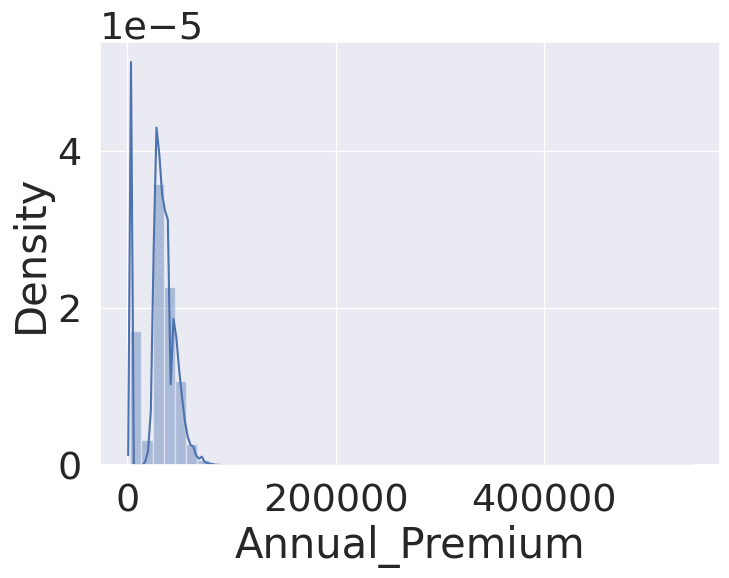

In [26]:
sns.distplot(df_train['Annual_Premium'])

<Axes: xlabel='Annual_Premium'>

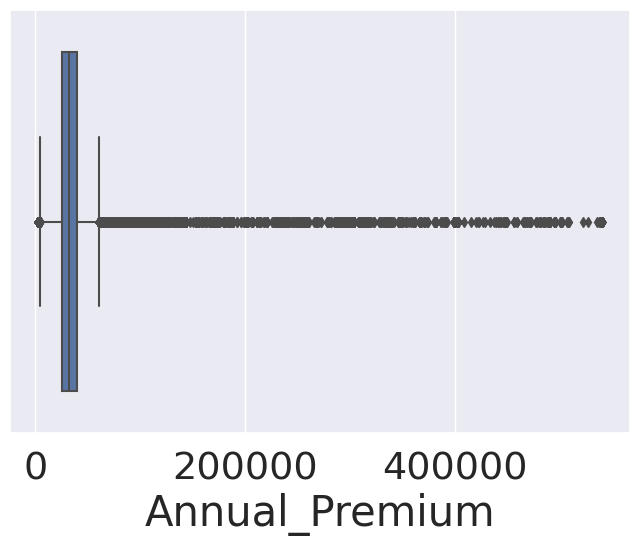

In [27]:
sns.boxplot(x=df_train['Annual_Premium'])

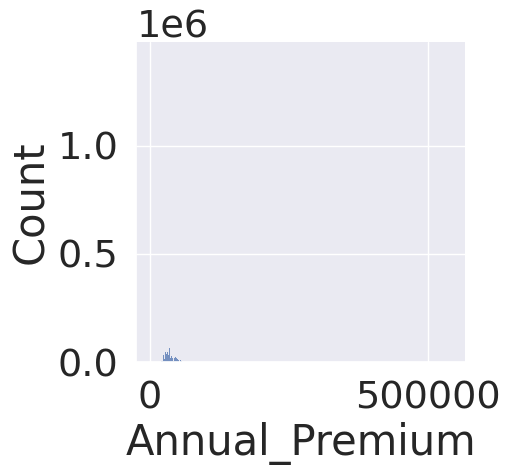

In [29]:
sns.displot(df_test["Annual_Premium"]) 

<Axes: xlabel='Annual_Premium'>

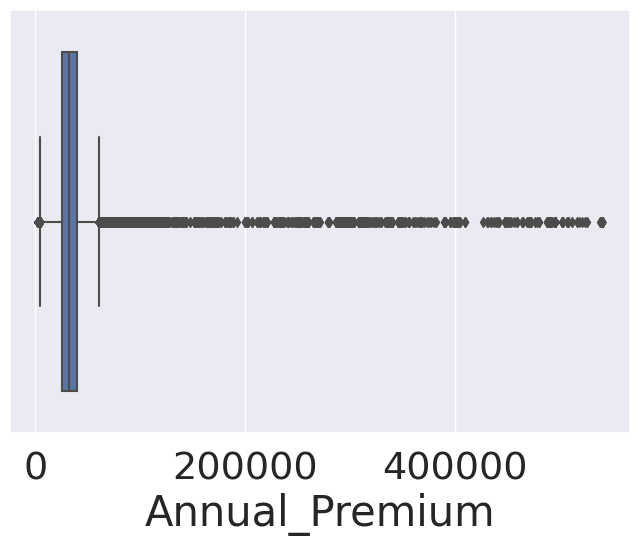

In [33]:
sns.boxplot(x=df_test['Annual_Premium'])

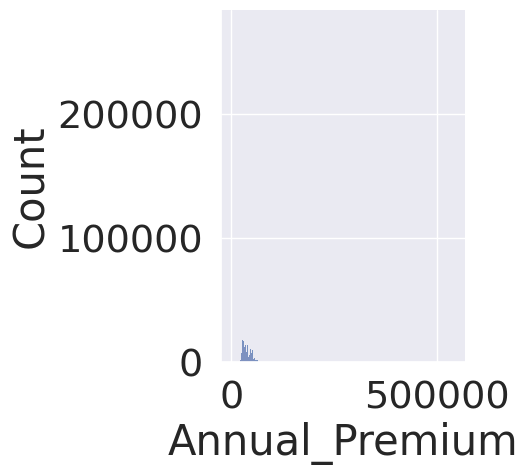

In [42]:
sns.displot(df_train[df_train['Response'] == 1]['Annual_Premium'])

# Vintage
수치 데이터

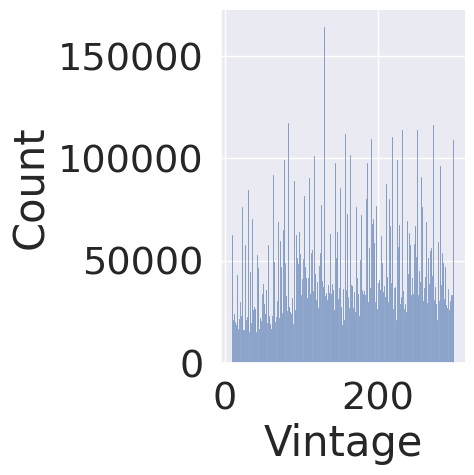

In [34]:
sns.displot(df_train["Vintage"]) 

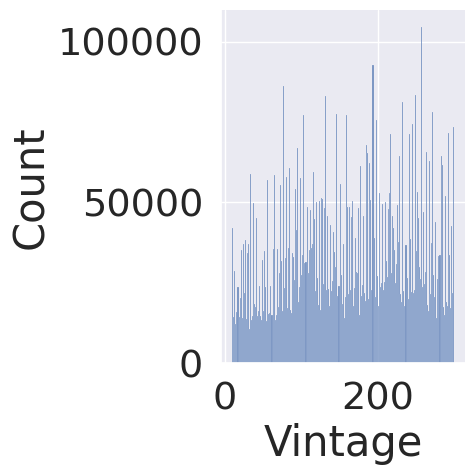

In [35]:
sns.displot(df_test["Vintage"]) 

<Axes: xlabel='Vintage'>

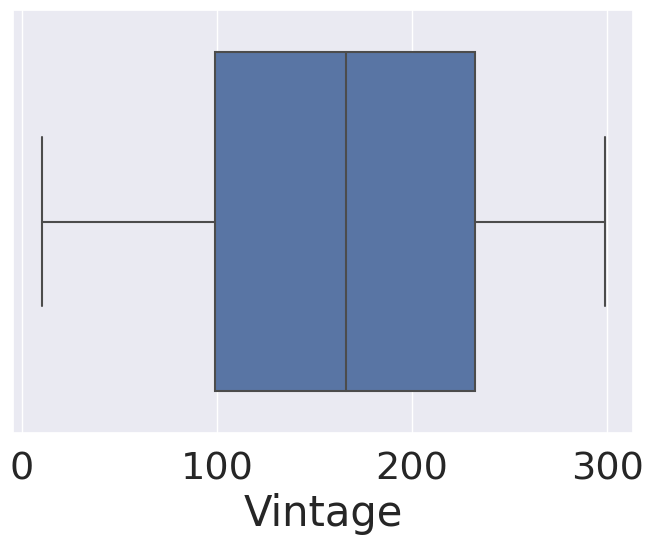

In [36]:
sns.boxplot(x=df_train['Vintage'])

<Axes: xlabel='Vintage'>

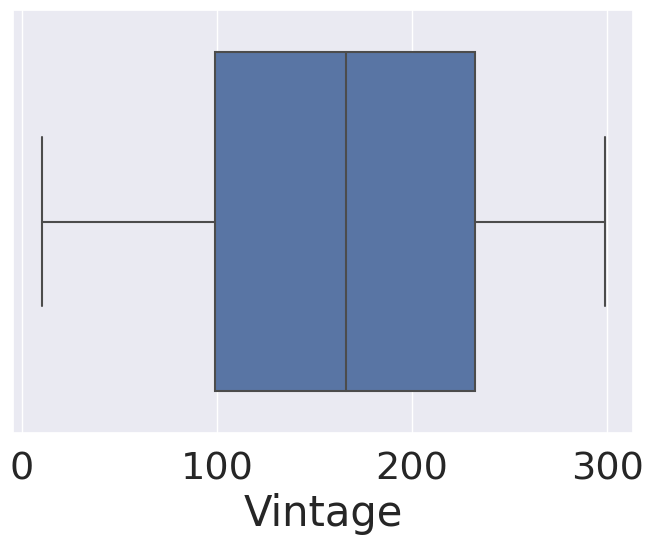

In [37]:
sns.boxplot(x=df_test['Vintage'])

번외. 로그값 취할때 왼쪽에 취우친 데이터 대상으로 한다 했던것.

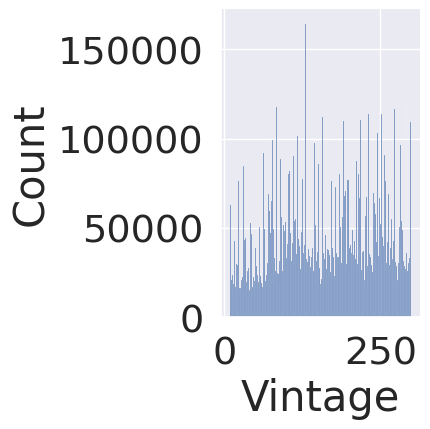

In [8]:
sns.displot(df_train["Vintage"])

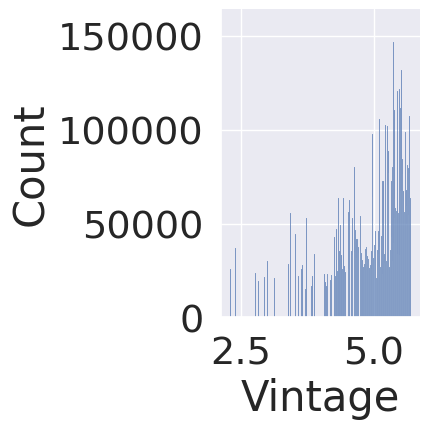

In [9]:
sns.displot(np.log(df_train["Vintage"]))